<img src="images/oc-banner-project-04-1660-v1.png" width="1000" />

# 🟣 Projet 4 - Construisez un modèle de scoring (Partie 2)

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Etudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 🚂 Partie 2 : Entraînement des modèles 

Ce second notebook se concentre sur l'**entraînement des modèles** de machine learning afin de **prédire le défaut de paiement** des clients. Après avoir effectué l'analyse exploratoire des données dans la première partie, nous passons ici au preprocessing et à la création, la sélection et l'évaluation des modèles prédictifs.

## 📝 Contexte

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt. Pour accorder un crédit à la consommation, l’entreprise souhaite **mettre en œuvre un outil de “scoring crédit”** qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Les chargés de relation client seront les utilisateurs de l’outil de scoring et ont besoin que le modèle soit facilement interprétable, avec une mesure de l’importance des variables influençant la décision.

## ⚡ Mission

>  Développer un outil de **scoring crédit** qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : **crédit accordé** ou **refusé**.

Le modèle doit être :
- **Interprétable** par les équipes qui vont l’utiliser
- Disposer d’une **mesure de l’importance des variables**
- Prendre en compte le **déséquilibre entre le nombre de bons et de moins bons clients**
- Prendre en compte le **coût métier** entre un faux négatif (FN) et un faux positif (FP)

## ⚙️ Installation et importation des bibliothèques nécessaires

In [2]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st # perform correlation calculation
import pickle
import os

In [3]:
# Intel® Extension for Scikit-learn*
# https://uxlfoundation.github.io/scikit-learn-intelex/2024.6/index.html

from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
# Apply the default theme for seaborn
sns.set_theme()

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Téléchargement et extraction du fichier .zip.

In [7]:
%%time
import os

# Check if the directory exists
if not os.path.exists('./content/data'):
    # Execute the commands if the directory does not exist
    os.system('wget "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip" -O temp.zip')
    os.system('mkdir -p ./content/data')
    os.system('unzip -o temp.zip -d ./content/data')
    os.system('rm temp.zip')
    os.system('rm -rf ./content/data/__MACOSX')
else:
    print("Directory ./content/data already exists.")

Directory ./content/data already exists.
CPU times: user 274 μs, sys: 39 μs, total: 313 μs
Wall time: 255 μs


## Données d'entraînement

In [8]:
application_train_raw = pd.read_csv('./content/data/application_train.csv')
print(f"Les données d'entraînement contiennent : \n- {application_train_raw.shape[0]} observations (chacune étant une demande de prêt distinct)\n- {application_train_raw.shape[1]} variables, y compris la cible `TARGET` (la classe que nous voulons prédire)")

Les données d'entraînement contiennent : 
- 307511 observations (chacune étant une demande de prêt distinct)
- 122 variables, y compris la cible `TARGET` (la classe que nous voulons prédire)


In [9]:
application_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [10]:
application_train_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## ✂️ Division en ensemble d'entraînement et de test

La division sépare le jeu de données en deux parties : un **ensemble d'entraînement** utilisé pour entraîner le modèle et un **ensemble de test** utilisé pour évaluer ses performances sur des données inédites.

**Risques de Data Leakage** : L'ensemble de données de test ne doit en aucun cas être utilisé pour faire des choix concernant le modèle, y compris le**Feature Engineering**, **Feature Selection** et **Preprocessing**.

In [11]:
# Séparation des variables d'entraînement et de la cible
y = application_train_raw['TARGET']
X = application_train_raw.drop('TARGET', axis=1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print("Taille de X_train :", X_train.shape)
print("Taille de X_test :", X_test.shape)

Taille de X_train : (246008, 121)
Taille de X_test : (61503, 121)


## ⚗️ Feature Engineering

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20231220095556/Feature-Engineering.png" width=600 />

> **Feature Engineering** = Data Preparation + Preprocessing

Le **Feature engineering** est un processus de transformation de données brutes. Il consiste à choisir, extraire et remodeler les variables les plus appropriées pour créer des modèles de Machine Learning **précis et performants**. L’efficacité d’un modèle d’apprentissage est liée à la **qualité des variables utilisées** pour le former.

> Le Feature Engineering est le processus de transformation des données brutes en variables adaptées aux modèles d'apprentissage automatique.

Les objectifs du **Feature Engineering** sont de :

- **Sélectionner les variables pertinentes** des données (Feature selection).
- **Créer de nouvelles variables** permettant de capturer des relations significatifs (Feature creation).
- **Transformer les données dans un format plus adapté** aux algorithmes de Machine Learning (Preprocessing).

Les deux facteurs moteurs du **Feature engineering** sont :
1. La **connaissance métier** de la tâche (domain knowledge)
2. L’inspection des valeurs des données.

Le feature engineering englobe différentes techniques permettant de créer de nouvelles variables en combinant ou en modifiant les existantes :

- **Feature Extraction** (images, textes) : transforme les données brutes en une représentation plus significative pour les modèles.
- **Feature Selection / Feature Importance** : processus de sélection d’un sous-ensemble de fonctionnalités pertinentes à partir de l’ensemble de données à utiliser dans un modèle.
- **Feature Creation** : génération de nouvelles variables basées sur des connaissances métier ou en observant des motifs dans les données.
- **Feature Scaling** : standardisation des variables afin qu'elles aient une échelle similaire.
- **Feature Transformation** : préparation en encodage des données

> Objectif : **Créez au moins trois nouvelles variables pertinentes** à partir des variables existantes (interactions, transformations).



### Data Preparation

<img src="https://github.com/Clearbox-AI/clearbox-wrapper/blob/master/docs/images/clearbox_ai_wrapper_preprocessing_data_preparation.png?raw=true" width="600" />

Suite à l'analyse exploratoire des données réalisées dans un précédent notebook, des **transformations sont appliquées** pour améliorer la qualité et la pertinence des variables.

Ces étapes permettent de réduire le bruit dans les données, de traiter les valeurs manquantes, de simplifier certaines variables catégoriques, et de créer de nouveaux ratios pertinents pour l'analyse.

Ces transformations visent à préparer un jeu de données optimisé pour les modèles de machine learning tout en assurant une interprétabilité adéquate des résultats.

**Préparation réalisée** :

- ✔️ Supprimer les colonnes inutiles ou dedondantes :
  - les identifiants `SK_ID_CURR`.
  - `WEEKDAY_APPR_PROCESS_START`
  - `AMT_GOODS_PRICE`
  - `CNT_FAM_MEMBERS`
  - `DEF_60_CNT_SOCIAL_CIRCLE`
  - `LIVINGAPARTMENTS_AVG`
  - `LIVINGAREA_AVG`
  - Les colonnes terminant par `_MODE` et `_MEDI`
- ✔️ Créer des tranches d'heure pour `HOUR_APPR_PROCESS_START`.
- ✔️ Transformer `NAME_INCOME_TYPE` : Combiner les types de revenus à faible nombre de clients dans la modalité "Other".
- ✔️ Créer une modalité qui regroupe "4 enfants et plus" (`4`) pour `CNT_CHILDREN`.
- ✔️ Création de ratios
  - `RATIO_DEBT_INCOME`
  - `RATIO_ANNUITY_INCOME`
  - `RATIO_ANNUITY_CREDIT`
  - `RATIO_DAYS_EMPLOYED_AGE`
- ✔️ Remplacer les valeurs manquantes par une modalité qui existe déjà :
  - `FONDKAPREMONT_MODE` : "not specified"
  - `CODE_GENDER` : "XNA"
  - `NAME_TYPE_SUITE` : "Unaccompanied"
- ✔️ Convertir les colonnes contenant les valeurs "Y" et "N" en 0 et 1 et remplir les valeurs manquantes avec 0
  - `FLAG_OWN_CAR`
  - `FLAG_OWN_REALTY`
  - `EMERGENCYSTATE_MODE`
- ✔️ Remplir les valeurs NaN pour l'age de la voiture `OWN_CAR_AGE` :
  - Pour les propriétaires de voitures (`FLAG_OWN_CAR` == 'Y') : avec la médiane
  - Pour les non-propriétaires de voitures (`FLAG_OWN_CAR` == 'N') : avec 0

  **Documentation**

- https://github.com/Clearbox-AI/clearbox-wrapper

In [14]:
def preparation(df):

  # Selection des variables
  features = [
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'EMERGENCYSTATE_MODE',
    'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'FLAG_MOBIL',
    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
    'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
    'OWN_CAR_AGE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED',
    'DAYS_LAST_PHONE_CHANGE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_MON', 'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_1',
    'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
    'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'TOTALAREA_MODE',
    'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START'
  ]
  missing_columns = [col for col in features if col not in df.columns]
  if missing_columns:
    raise ValueError(f"Some columns are missing from the dataframe: {missing_columns}")
  df = df[features].copy()

  # Remplacez les valeurs manquantes par une modalité qui existe déjà
  df['FONDKAPREMONT_MODE'] = df['FONDKAPREMONT_MODE'].fillna('not specified')
  df['CODE_GENDER'] = df['CODE_GENDER'].fillna('XNA')
  df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna('Unaccompanied')

  # Remplissez les valeurs NaN de `OWN_CAR_AGE`
  # - Pour les propriétaires de voitures (1) : utiliser la médiane
  # - Pour les non-propriétaires de voitures (0) : utilisez 0
  # Never recalculate imputation parameters on test set
  median_car_age = df[df['FLAG_OWN_CAR'] == 'Y']['OWN_CAR_AGE'].median()
  df['OWN_CAR_AGE'] = df.apply(lambda row: median_car_age if row['FLAG_OWN_CAR'] == 'Y' else 0, axis=1)

  # Convertir les colonnes contenant les valeurs "Y" et "N" en 0 et 1 et remplir les valeurs manquantes avec 0
  df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1}).fillna(0).astype(int)
  df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1}).fillna(0).astype(int)
  df['EMERGENCYSTATE_MODE'] = df['EMERGENCYSTATE_MODE'].map({'No': 0, 'Yes': 1}).fillna(0).astype(int)

  # Correction des valeurs aberrantes dans les jours d'emploi (DAYS_EMPLOYED)
  # There are 55374 anomalous days of employment == 365243
  # Comme c'est une erreur (et non un outlier), nous allons imputer la médiane (plutot que de clip).
  if 'DAYS_EMPLOYED' in df.columns:
    # anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
    anom = df[df['DAYS_EMPLOYED'] > 25000]
    df['DAYS_EMPLOYED_ANOM'] = (df["DAYS_EMPLOYED"] > 25000).astype(int)  # Binary column (0 or 1)
    df.loc[df['DAYS_EMPLOYED'] > 25000, 'DAYS_EMPLOYED'] = np.nan  # Replace anomalies with NaN

  # Création de ratios
  # Debt to income ratio
  df['RATIO_DEBT_INCOME'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
  # Annuity to income ratio
  df['RATIO_ANNUITY_INCOME'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
  # Annuity to credit ratio
  df['RATIO_ANNUITY_CREDIT'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
  # Days employed to age
  df['RATIO_DAYS_EMPLOYED_AGE'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

  # NAME_INCOME_TYPE : Combiner les types de revenus à faible nombre dans la modalité "Other".
  value_counts = df['NAME_INCOME_TYPE'].value_counts()
  low_count_categories = value_counts[value_counts < 100].index
  df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace(low_count_categories, 'Other')

  # CNT_CHILDREN : Créer une modalité qui regroupe "4 enfants et plus" (4).
  df.loc[df['CNT_CHILDREN'] >= 4, 'CNT_CHILDREN'] = 4

  # HOUR_APPR_PROCESS_START : Tranches d'heure pour `HOUR_APPR_PROCESS_START`.
  if 'HOUR_APPR_PROCESS_START' in df.columns:
    df['HOUR_GROUP'] = pd.cut(df['HOUR_APPR_PROCESS_START'], bins=[-1, 5, 11, 17, 23], labels=['Early Morning', 'Morning', 'Afternoon', 'Evening'])
    df.drop(columns=['HOUR_APPR_PROCESS_START'], inplace=True)

  # Conversion des variables catégorielles au dtype 'category'
  for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

  return df

In [15]:
X_train_prepared = preparation(X_train)
X_test_prepared = preparation(X_test)

In [16]:
print(X_train_prepared.shape)
print(X_test_prepared.shape)

(246008, 91)
(61503, 91)


#### Valeurs manquantes

In [17]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
  # Total missing values
  mis_val = df.isnull().sum()

  # Percentage of missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df)

  # Make a table with the results
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

  # Rename the columns
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Valeurs manquantes', 1 : '% des valeurs totales'})

  # Sort the table by percentage of missing descending
  mis_val_table_ren_columns = mis_val_table_ren_columns[
      mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
  '% des valeurs totales', ascending=False).round(1)

  # Print some summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
      "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")

  # Return the dataframe with missing information
  return mis_val_table_ren_columns

In [18]:
# Missing values statistics
missing_values = missing_values_table(X_train_prepared)
missing_values.head(40)

Your selected dataframe has 91 columns.
There are 34 columns that have missing values.


,Valeurs manquantes,% des valeurs totales
COMMONAREA_AVG,171929,69.9
NONLIVINGAPARTMENTS_AVG,170868,69.5
FLOORSMIN_AVG,166954,67.9
YEARS_BUILD_AVG,163683,66.5
LANDAREA_AVG,146129,59.4
BASEMENTAREA_AVG,144015,58.5
EXT_SOURCE_1,138524,56.3
NONLIVINGAREA_AVG,135943,55.3
ELEVATORS_AVG,131208,53.3
WALLSMATERIAL_MODE,125179,50.9


### Preprocessing : Formatage des données

Ce code crée un **pipeline de prétraitement** utilisant `Scikit-learn` pour gérer les données numériques et catégorielles, y compris les valeurs manquantes.

1. **Imputation des valeurs manquantes**
2. **Encodage des variables catégorielles** en format numérique (encodage one-hot, label encoding).
3. **Standardisation des variables numériques**.

**Documentation**

- https://scikit-learn.org/stable/modules/impute.html
- https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor
- https://scikit-learn.org/1.5/modules/preprocessing.html

Chaque type de variable bénéficiera d'un pré-processing particulier.

1. 🔴 **Colonnes catégoriques (`cat_cols`)**  
   - **Imputation** : Remplacement des valeurs manquantes par la constante `'missing'`.  
   - **Encodage** : Encodage "One-Hot Encoding", avec suppression de la première catégorie pour éviter la colinéarité. Les catégories inconnues dans les données de test sont ignorées.  
   - **Pipeline utilisé** : `pp_cat`  

2. 🟠 **Colonnes binaires (`binary_cols`)**  
   - **Imputation** : Remplacement des valeurs manquantes par `0`.  
   - **Pipeline utilisé** : `pp_binary`  

3. 🟡 **Colonnes quantitatives (`quantity_cols`)**  
   - **Imputation** : Remplacement des valeurs manquantes par la médiane.  
   - **Normalisation** : Utilisation de `RobustScaler` pour réduire l'influence des valeurs aberrantes (outliers).  
   - **Pipeline utilisé** : `pp_quantity`  

4. 🟢 **Colonnes normalisées (`normalized_cols`)**  
   - **Imputation** : Remplacement des valeurs manquantes par la médiane.  
   - **Pipeline utilisé** : `pp_normalized`  

5. 🔵 **Colonnes d’évaluation ou de notation (`rating_cols`)**  
   - **Imputation** : Remplacement des valeurs manquantes par la valeur la plus fréquente.  
   - **Normalisation** : Mise à l’échelle dans l'intervalle [0, 1] grâce à `MinMaxScaler`.  
   - **Pipeline utilisé** : `pp_rating`  

Tous ces sous-pipelines sont combinés dans un `ColumnTransformer` nommé `preprocessor`. Chaque groupe de colonnes est traité par son pipeline respectif pour garantir un prétraitement adapté à la nature des données.

Ce pipeline assure ainsi une gestion robuste et flexible des valeurs manquantes, de l'encodage et de la normalisation pour différents types de colonnes dans le jeu de données.


In [19]:
# Categorical Columns
cat_cols = [
  'CODE_GENDER', 'NAME_CONTRACT_TYPE',
  'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
  'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
  'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
  'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
  'HOUR_GROUP'
]

# Binary Columns
binary_cols = [
  'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
  'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
  'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
  'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
  'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
  'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
  'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
  'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
  'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
  'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
  'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
  'DAYS_EMPLOYED_ANOM',
  'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE'
]

# Quantity Columns
quantity_cols = [
  'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
  'OWN_CAR_AGE', 'DAYS_BIRTH', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
  'DAYS_EMPLOYED', 'DAYS_LAST_PHONE_CHANGE',
  'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
  'OBS_30_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
  'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
  'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_QRT',
  'AMT_REQ_CREDIT_BUREAU_MON',
  'RATIO_DEBT_INCOME', 'RATIO_ANNUITY_INCOME', 'RATIO_ANNUITY_CREDIT', 'RATIO_DAYS_EMPLOYED_AGE'
]

# Normalized Columns
normalized_cols = [
  'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
  'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
  'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
  'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
  'LANDAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
  'TOTALAREA_MODE'
]

# Rating Columns
rating_cols = [
  'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT'
]

In [20]:
# @title Vérifiez que le DataFrame contient toutes les colonnes spécifiées et aucune colonne supplémentaire.
def validate_dataframe_columns(df: pd.DataFrame, *column_lists) -> None:
  """
  Vérifiez que le DataFrame contient toutes les colonnes spécifiées et aucune colonne supplémentaire.

  Parameters:
      df (pd.DataFrame): Le DataFrame à valider.
      *column_lists (list of lists): N'importe quel nombre de listes contenant des noms de colonnes.
  """
  # Combine all column lists into a single list
  all_columns = [col for column_list in column_lists for col in column_list]

  # Rechercher les colonnes manquantes
  missing_columns = [col for col in all_columns if col not in df.columns]
  if missing_columns:
      print(f"Les colonnes suivantes sont manquantes dans le DataFrame : {missing_columns}")
  else:
      print("Toutes les colonnes spécifiées sont présentes dans le DataFrame.")

  # Rechercher des colonnes inattendues dans le DataFrame
  unexpected_columns = [col for col in df.columns if col not in all_columns]
  if unexpected_columns:
      print(f"Les colonnes suivantes sont dans le DataFrame mais pas dans les variables définies : {unexpected_columns}")
  else:
      print("Toutes les colonnes du DataFrame sont prises en compte dans les variables définies.")


validate_dataframe_columns(
  X_train_prepared,
  cat_cols,
  binary_cols,
  quantity_cols,
  normalized_cols,
  rating_cols
)

Toutes les colonnes spécifiées sont présentes dans le DataFrame.
Toutes les colonnes du DataFrame sont prises en compte dans les variables définies.


In [21]:
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pp_cat = Pipeline([
    ('cat_imp', SimpleImputer(strategy='constant', add_indicator=False, fill_value='missing')),
    ('cat_ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

pp_binary = Pipeline([
    ('binary_imp', SimpleImputer(strategy='constant', add_indicator=False, fill_value=0))
])

pp_quantity = Pipeline([
    ('quantity_imp', SimpleImputer(strategy='median', add_indicator=False)),
    ('quantity_scaler', RobustScaler()) # Traite les outliers
])

pp_normalized = Pipeline([
    ('normalized_imp', SimpleImputer(strategy='median', add_indicator=False))
])

pp_rating = Pipeline([
    ('rating_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
    ('rating_scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    # ('mi', MissingIndicator(), X_train_prepared.columns),
    ('pp_cat', pp_cat, cat_cols),
    ('pp_binary', pp_binary, binary_cols),
    ('pp_quantity', pp_quantity, quantity_cols),
    ('pp_normalized', pp_normalized, normalized_cols),
    ('pp_rating', pp_rating, rating_cols)
])

X_train_preprocessed = pd.DataFrame(preprocessor.fit_transform(X_train_prepared))
X_test_preprocessed = pd.DataFrame(preprocessor.transform(X_test_prepared))


In [22]:
# Visualisation des données d'entraînement encodées
print(X_train_preprocessed.shape)
X_train_preprocessed.head(2)

(246008, 196)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.075180,-0.470457,0.275,0.0,1.0,-1.045430,0.165997,-0.448798,0.000000,-1.003855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.005675,-0.587671,-0.755214,0.000000,0.035792,0.524685,0.358568,0.563835,0.0876,0.0763,0.9821,0.7552,0.0211,0.0,0.1379,0.1667,0.2083,0.0483,0.0000,0.0035,0.0687,0.5,0.5
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.587937,-0.069688,0.125,1.0,0.0,0.665474,0.040723,-0.057409,0.837349,0.526600,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,-0.637930,-0.111221,2.551124,-0.879446,0.010032,0.244926,0.490305,0.595456,0.0784,0.0633,0.9742,0.6464,0.0266,0.0,0.1379,0.1667,0.2083,0.0409,0.0039,0.0149,0.0645,0.5,0.5


In [23]:
# Visualisation des données de test encodées
print(X_test_preprocessed.shape)
X_test_preprocessed.head(2)

(61503, 196)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.091562,1.528675,0.675,2.0,1.0,0.338381,0.706172,-0.409620,0.484118,0.581342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.323029,0.801971,2.321541,-0.499314,0.009630,0.675878,0.604894,0.000527,0.0876,0.0763,0.9821,0.7552,0.0211,0.00,0.1379,0.1667,0.2083,0.0483,0.0000,0.0035,0.0687,0.5,0.5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.423810,1.325067,1.125,0.0,1.0,0.134499,0.528488,-0.502327,0.276561,-0.242868,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.608117,0.306546,-0.434601,-0.336931,0.006852,0.430827,0.425351,0.712155,0.0753,0.0568,0.9970,0.9592,0.1326,0.08,0.0517,0.4167,0.2917,0.0735,0.0058,0.1118,0.0754,1.0,1.0


## Gestion des classes déséquilibrées (Class Imbalance)

La variables cible `Target` contient :
- 91,9 % de classe `0`
- 8,1 % de classe `1` (Défaut de paiement)

Ce déséquilibre important dans la variable cible signifie que le modèle pourrait être biaisé en faveur de la classe majoritaire (`0`) s'il n'est pas correctement géré. En effet, un modèle non ajusté pourrait simplement prédire systématiquement la classe `0` pour maximiser son taux de précision globale, mais cela serait inutile pour détecter les cas critiques de défaut de paiement (classe `1`).

Il est donc essentiel d'appliquer des techniques adaptées :
- Le suréchantillonnage de la classe minoritaire (par exemple, SMOTE)
- L'utilisation de métriques d'évaluation comme la **précision**, le **rappel** (recall) ou l'**AUC-ROC**, qui tiennent compte de ce déséquilibre.


In [24]:
# Affichage du déséquilibre de la variable cible
y_train.value_counts()/len(y_train)*100

TARGET
0    91.920588
1     8.079412
Name: count, dtype: float64

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Define the oversampling strategy
over = SMOTE(sampling_strategy=0.3)
# Define the undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)

# Create the pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Apply the pipeline to the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_preprocessed, y_train)

# Display the class distribution before and after resampling
print(f'Original dataset shape: {Counter(y_train)}')
print(f'Resampled dataset shape: {Counter(y_train_resampled)}')

Original dataset shape: Counter({0: 226132, 1: 19876})
Resampled dataset shape: Counter({0: 135678, 1: 67839})


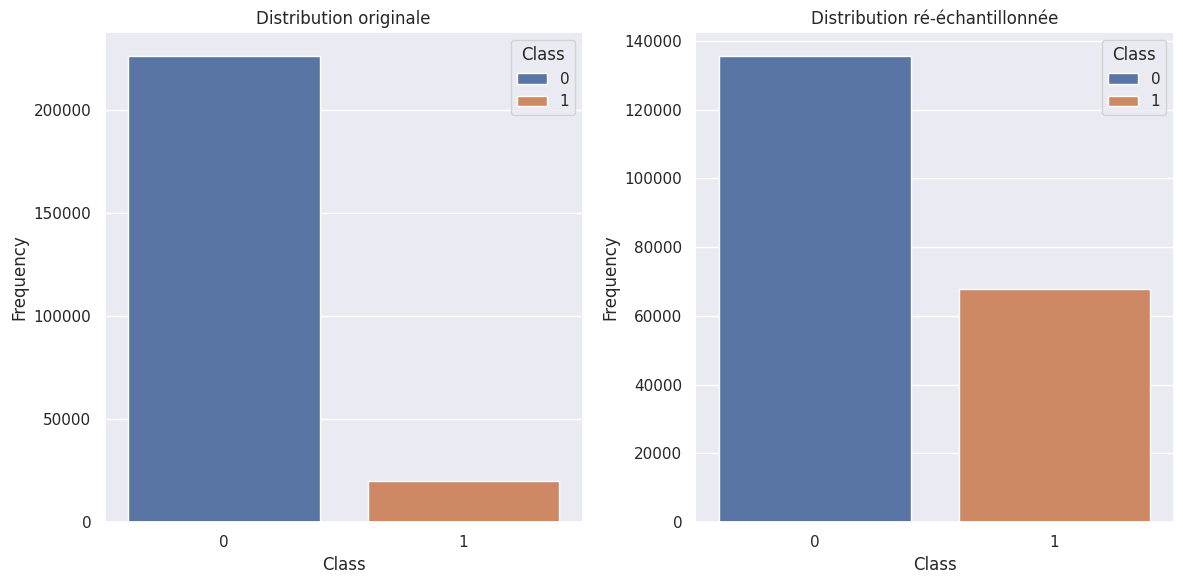

In [26]:
def plot_class_imbalance(y_train, y_train_resampled):
  # Convert to DataFrame for easier plotting
  df_original = pd.DataFrame({'Class': y_train})
  df_resampled = pd.DataFrame({'Class': y_train_resampled})

  # Plot the class distribution before and after resampling
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  sns.countplot(x='Class', data=df_original, ax=axes[0], hue='Class')
  axes[0].set_title('Distribution originale')
  axes[0].set_xlabel('Class')
  axes[0].set_ylabel('Frequency')

  sns.countplot(x='Class', data=df_resampled, ax=axes[1], hue='Class')
  axes[1].set_title('Distribution ré-échantillonnée')
  axes[1].set_xlabel('Class')
  axes[1].set_ylabel('Frequency')

  plt.tight_layout()
  plt.show()

plot_class_imbalance(y_train, y_train_resampled)

Nous pouvons désormais utiliser `X_train_resampled` et `y_train_resampled` pour entraîner notre modèle.

## 🚂 Entraînement d'un modèle de base : Régression logistique

- **Modèle de base** : Régression logistique  
- **Sortie attendue** : Probabilité associée à chaque prédiction  

**Objectifs**

1. Établir un point de départ pour évaluer les performances d'autres modèles plus complexes.  
2. Identifier les forces et les limites de la régression logistique sur ce problème.  
3. Utiliser ce modèle pour comprendre les seuils de classification et les impacts métier (faux positifs, faux négatifs).  

**Approche**  

1. **Prétraitement des données** :  
   - Normaliser les variables quantitatives.  
   - Encoder les variables catégoriques.  
   - Traiter les valeurs manquantes et les variables déséquilibrées.  

2. **Entraînement** :  
   - Entraîner une régression logistique avec des hyperparamètres simples. 
   - Utiliser la méthde `predict_proba()` pour prédire des probabilités et non des classes directement.  

3. **Évaluation** :  
   - Utiliser des métriques clés comme le **ROC AUC**, le **rappel**, la **précision** et le **F1-score**.  
   - Comparer les performances avec une classification naïve (par exemple, prédire toujours la classe majoritaire).  

4. **Analyse des seuils** :  
   - Étudier l’impact des différents seuils de classification sur les métriques métier.  
   - Tracer la courbe coût-métier pour choisir un seuil optimal.  

**Résultats attendus**  
- Une première évaluation des performances du modèle.  
- Une base de comparaison pour tester des modèles plus sophistiqués.  
- Un seuil initial pour minimiser les erreurs critiques (par exemple, les faux négatifs).  


**Documentation**

- [LogisticRegression — scikit-learn 1.5.2 documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html)
- https://scikit-learn.org/1.5/modules/linear_model.html#logistic-regression
- https://www.kaggle.com/discussions/questions-and-answers/206121
- https://www.geeksforgeeks.org/gpu-acceleration-in-scikit-learn/




### Entrainement

In [27]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

lr_base_v01_path = './content/artefacts/model-lr-base-v01.pkl'
is_training = False

if is_training:

    # Initialize Logistic Regression
    lr_base_v01 = LogisticRegression(
        n_jobs=-1,
        random_state=42
    )

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    roc_auc_scores = []
    for train_index, val_index in skf.split(X_train_resampled, y_train_resampled):
        
        X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
        y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

        lr_base_v01.fit(X_train_fold, y_train_fold)

        y_pred_proba = lr_base_v01.predict_proba(X_val_fold)[:, 1]
        roc_auc = roc_auc_score(y_val_fold, y_pred_proba)
        roc_auc_scores.append(roc_auc)

    # Display average ROC AUC score across folds
    print(f"Average ROC AUC score across folds: {np.mean(roc_auc_scores)}")

    # Entraînement du modèle sur l'ensemble des données d'entraînement
    lr_base_v01.fit(X_train_resampled, y_train_resampled)

    # Save the model
    with open(lr_base_v01_path, 'wb') as model_file:
        pickle.dump(lr_base_v01, model_file)

# 51 minutes

CPU times: user 18 μs, sys: 2 μs, total: 20 μs
Wall time: 24.3 μs


In [28]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

is_training = False
lr_base_v02_path = './content/artefacts/model-lr-base-v02.pkl'

if is_training:

    # Initialize Logistic Regression
    lr_base_v02 = LogisticRegression(
        penalty='l1',
        C=100,
        solver='liblinear',
        n_jobs=-1,
        verbose=3,
        random_state=42
    )

    # Entraînement du modèle sur l'ensemble des données d'entraînement
    lr_base_v02.fit(X_train_resampled, y_train_resampled)

    # Save the model
    with open(lr_base_v02_path, 'wb') as model_file:
        pickle.dump(lr_base, model_file)


CPU times: user 22 μs, sys: 0 ns, total: 22 μs
Wall time: 26.5 μs


### Prédiction sur le jeu de test

Par défaut, `lr.predict` utilise un seuil de 0,5 pour classer les échantillons.

In [29]:
# Charger le modèle
with open(lr_base_v02_path, 'rb') as model_file:
    loaded_model_lr_base = pickle.load(model_file)

In [30]:
# Prédiction sur le jeu de test
y_pred = loaded_model_lr_base.predict(X_test_preprocessed)
y_proba = loaded_model_lr_base.predict_proba(X_test_preprocessed)[:,1]

## Métriques

1. **ROC AUC Score**  
   - **Définition** : Mesure la capacité du modèle à séparer les classes (discrimination) en calculant l'aire sous la courbe ROC.  
   - **Interprétation** : Plus proche de 1, meilleure est la performance globale du modèle sur toutes les valeurs de seuils.

2. **Recall (Rappel)**  
   - **Définition** : Proportion des instances positives correctement identifiées par le modèle.  
   - **Formule** : TP / (TP + FN)
   - **Interprétation** : Important dans les cas où **détecter les positifs (classe 1) est critique** (par exemple, défaut de paiement).  

3. **Precision for class 1 (Précision)**  
   - **Définition** : Proportion des instances prédites comme positives qui sont réellement positives.  
   - **Formule** : TP / (TP + FP) 
   - **Interprétation** : Utile pour **éviter les faux positifs**.  

4. **F1 Score**  
   - **Définition** : Moyenne harmonique de la précision et du rappel.  
   - **Formule** : 2 x ((Precision * Recall) / (Precision + Recall))
   - **Interprétation** : Équilibre entre précision et rappel, particulièrement utile lorsque les classes sont déséquilibrées.  

5. **F2 Score**  
   - **Définition** : Variante du F1-score qui accorde **plus d'importance au rappel** (détection des positifs) qu'à la précision.  
   - **Formule** : (1 + 2²) * [(P * R) / ((2² * P) + R)]
   - **Interprétation** : Utile lorsque **minimiser les faux négatifs** est prioritaire, car il **privilégie le recall** par rapport à la précision.  

Ces métriques permettent une évaluation complète du modèle en termes de discrimination (ROC AUC), sensibilité (Rappel), exactitude sur les prédictions positives (Précision), et équilibre global (F1).

### Classification Report

In [31]:
from sklearn.metrics import classification_report

# Rapport de prédictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56554
           1       0.22      0.41      0.29      4949

    accuracy                           0.84     61503
   macro avg       0.58      0.64      0.60     61503
weighted avg       0.89      0.84      0.86     61503



### Métriques : ROC AUC, Recall, Precision, F1

In [32]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, fbeta_score

def display_performance_metrics(y_true, y_proba, y_pred):
    """
    Affiche les métriques de performance du modèle.
    """
    roc_auc = roc_auc_score(y_true, y_proba)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)

    print(f"ROC AUC Score : {roc_auc}")
    print(f"Recall Score : {recall}")
    print(f"Precision : {precision}")
    print(f"F1 Score : {f1}")
    print(f"F2 Score : {f2}")

# Assuming y_test, y_proba, and y_pred are defined
display_performance_metrics(y_test, y_proba, y_pred)

ROC AUC Score : 0.742909822924673
Recall Score : 0.413012729844413
Precision : 0.2246153846153846
F1 Score : 0.2909815645241654
F2 Score : 0.3536821705426357


### Courbe ROC

La courbe ROC (**Receiver Operating Characteristic**) est un outil graphique utilisé pour évaluer la performance d'un modèle de classification binaire. Elle montre la relation entre le **taux de vrais positifs** (sensibilité ou rappel) et le **taux de faux positifs** à différents seuils de détection.  

Chaque point sur la courbe correspond à un seuil de détection spécifique utilisé pour convertir les probabilités prédites en classes. En fonction des besoins du problème, vous pouvez choisir un seuil qui équilibre ces deux métriques.  

- **Taux de vrais positifs** : proportion de positifs correctement prédits.  
- **Taux de faux positifs** : proportion de négatifs incorrectement prédits comme positifs.  

**L'aire sous la courbe (AUC - Area Under Curve)** mesure la capacité globale du modèle à discriminer entre les classes : une AUC proche de 1 indique une excellente performance, tandis qu'une AUC de 0,5 correspond à un modèle aléatoire.

La courbe ROC aide à choisir un seuil de détection optimal en fonction des besoins (par exemple, minimiser les faux négatifs).

- **Minimiser les faux négatifs** : On cherche un point sur la courbe où le taux de vrais positifs est élevé, même si cela implique un taux de faux positifs plus important. Cela garantit que le modèle détecte la majorité des cas positifs (classe 1).  
- Une courbe proche du coin supérieur gauche indique une bonne performance (rappel élevé avec peu de faux positifs).  

Le seuil idéal dépend des priorités. Par exemple, pour minimiser les faux négatifs, choisissez un point avec un taux de vrais positifs élevé, même si le taux de faux positifs est acceptable.  

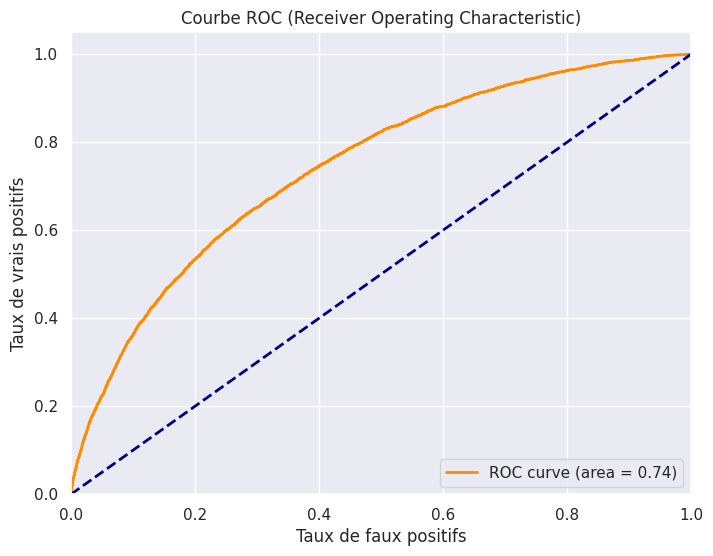

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def plot_roc_curve(y_true, y_proba):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC (Receiver Operating Characteristic)')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test, y_proba)

### Matrice de confusion

La **matrice de confusion** est un outil qui permet d'évaluer la performance d'un modèle de classification en comparant les prédictions aux valeurs réelles. Elle présente le nombre de **vrais positifs**, **faux positifs**, **vrais négatifs** et **faux négatifs**, offrant ainsi une vue d'ensemble des erreurs de classification.

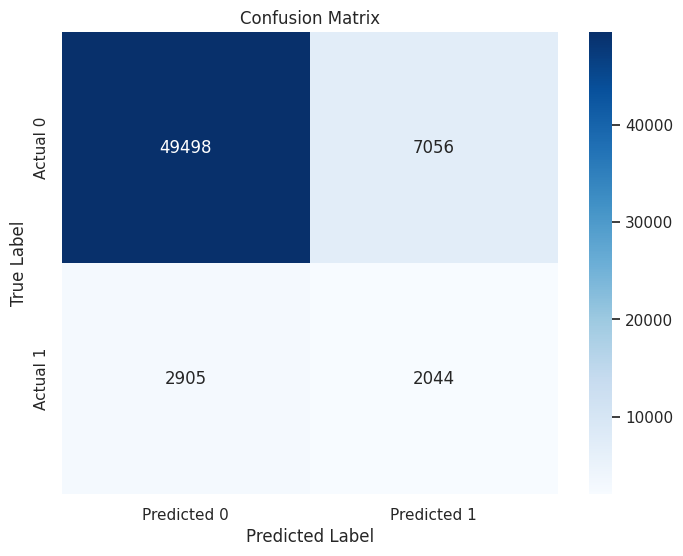

In [34]:
from sklearn.metrics import confusion_matrix

def display_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

display_cm(y_test, y_pred)

### Précision, rappel et F1-score en fonction du seuil de détection

Nous visualisons l'évolution de la précision, du rappel et du F1-score en fonction du **seuil de détection** pour convertir les probabilités prédites en classes. En ajustant le seuil, on peut observer comment le modèle équilibre ces métriques : 
- **un seuil plus bas favorise le rappel** (détection des vrais positifs)
- un seuil plus élevé privilégie la précision (réduction des faux positifs).

L'objectif est de **minimiser les faux négatifs**. Il faut donc privilégier un **rappel (recall)** élevé, car cette métrique mesure la capacité du modèle à identifier correctement toutes les instances positives (classe 1). Cela peut nécessiter un seuil de détection plus bas, ce qui augmente la détection des vrais positifs au détriment potentiel de la précision. Le graphique permet d'identifier le seuil qui maximise le rappel tout en maintenant un F1-score acceptable pour équilibrer globalement la performance.

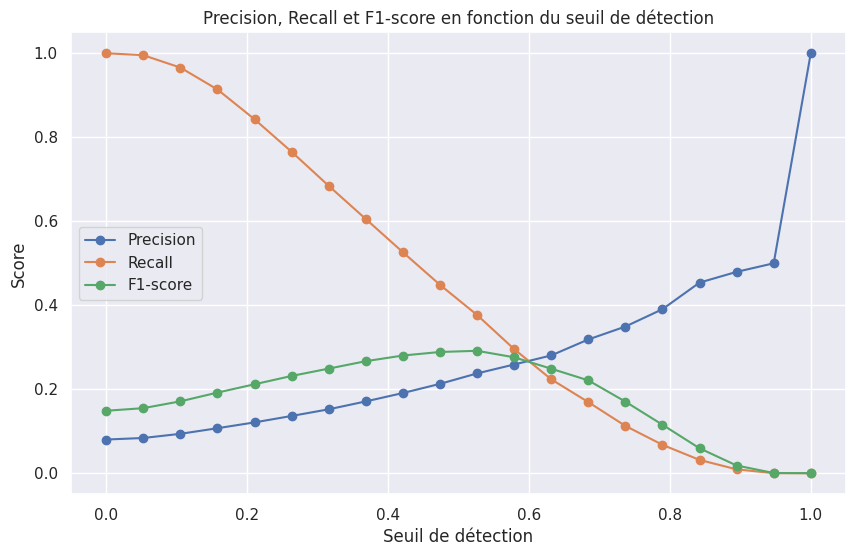

In [35]:
# Visualisation de precision recall F1 score sur le meme graphique en fonction du seuil
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def precision_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate precision
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    return precision

def recall_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate recall
    recall = recall_score(y_true, y_pred, pos_label=1)
    return recall

def f1_at_threshold(y_true, y_pred_proba, threshold):
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    # Calculate f1-score
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return f1

def plot_metrics_vs_threshold(y_true, y_pred_proba):

    # Calculate precision, recall and f1-score for different thresholds
    thresholds = np.linspace(0, 1, 20)
    precisions = []
    recalls = []
    f1_scores = []

    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred, pos_label=1, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, pos_label=1))
        f1_scores.append(f1_score(y_true, y_pred, pos_label=1))

    # Visualize the results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, marker='o', label='Precision')
    plt.plot(thresholds, recalls, marker='o', label='Recall')
    plt.plot(thresholds, f1_scores, marker='o', label='F1-score')
    plt.title('Precision, Recall et F1-score en fonction du seuil de détection')
    plt.xlabel('Seuil de détection')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the results
    # for threshold, precision, recall, f1 in zip(thresholds, precisions, recalls, f1_scores):
    #     print(f"Seuil de détection {threshold}: Precision = {precision:.4f}, Recall = {recall:.4f}, F1-score = {f1:.4f}")

plot_metrics_vs_threshold(y_test, y_proba)

### Fonction de coût métier

Pour aligner le modèle sur les enjeux métier, une **fonction de coût métier** est définie, intégrant les coûts associés aux erreurs de classification :  

- **Faux positif (FP)** : Un client est considéré comme "mauvais payeur" alors qu'il est en réalité "bon payeur". Cela entraîne un manque à gagner pour la banque.  
- **Faux négatif (FN)** : Un client est considéré comme "bon payeur" alors qu'il est en réalité "mauvais payeur". C'est une erreur coûteuse, car la banque prend un risque élevé de non-remboursement.  

Le **modèle prédictif** retourne une probabilité que le client soit un "mauvais payeur" (`TARGET: 1`).  

> Cout métier = FP + 10 * FN

Cela reflète la priorité donnée à la réduction des faux négatifs.

**Étapes pour déterminer le seuil optimal :**  

1. Prédire les probabilités pour chaque client.  
2. Appliquer plusieurs **seuils de détection** pour classifier les clients comme "bons" (0) ou "mauvais payeurs" (1).  
3. Comparer les prédictions avec les valeurs réelles (`y_test`).  
4. **Calculer le coût métier** pour chaque seuil en utilisant la formule ci-dessus.  
5. Répéter l’opération pour différents seuils et **tracer la courbe du coût métier** en fonction des seuils.  
6. **Identifier le seuil optimal**, celui qui **minimise le coût métier**.

Ressources :
- https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning

Threshold: 0.00, Custom Score: 56554
Threshold: 0.10, Custom Score: 48307
Threshold: 0.20, Custom Score: 38570
Threshold: 0.30, Custom Score: 34777
Threshold: 0.40, Custom Score: 34201
Threshold: 0.50, Custom Score: 36106
Threshold: 0.60, Custom Score: 39914
Threshold: 0.70, Custom Score: 43544
Threshold: 0.80, Custom Score: 47015
Threshold: 0.90, Custom Score: 49142
Threshold: 1.00, Custom Score: 49480


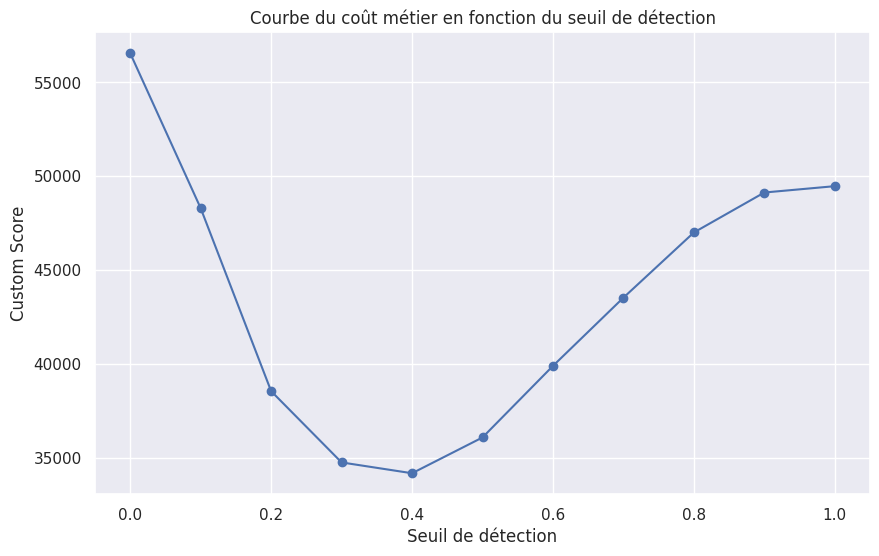

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix

def eval_custom_score_vs_thresholds(y_true, y_proba, thresholds=np.arange(0.0, 1.1, 0.1)):
    """
    Evaluation de différents scores métier en fonction du seuil de détection.

    Arguments:
    - y_true (np.array): Valeurs réelles de la variable cible
    - y_proba (np.array): Probabilités prédites de la classe positive
    - thresholds (list): Liste des seuils de détection

    returns:
        - Liste de tuples (seuil, score)
    """
    scores = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        custom_score =  (10 * fn) + fp
        scores.append((threshold, custom_score))
    return scores

def display_custom_score_vs_thresholds(scores):
    """
    Affiche les scores métier pour chaque seuil de détection.
    """
    for threshold, score in scores:
        print(f"Threshold: {threshold:.2f}, Custom Score: {score}")

def plot_custom_score_vs_threshold(scores):
    """
    Affiche un graphique du score métier en fonction du seuil de détection.
    """
    threshold_values, score_values = zip(*scores)
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_values, score_values, marker='o')
    plt.title('Courbe du coût métier en fonction du seuil de détection')
    plt.xlabel('Seuil de détection')
    plt.ylabel('Custom Score')
    plt.grid(True)
    plt.show()

# Evaluation de différents scores métier en fonction du seuil de détection
scores_metier = eval_custom_score_vs_thresholds(y_test, y_proba)
display_custom_score_vs_thresholds(scores_metier)
plot_custom_score_vs_threshold(scores_metier)


### Fonctions pour charger et évaluer un modèle

In [37]:
def load_model(model_filepath: str):

    if not os.path.exists(model_filepath):
        print(f"Le fichier {model_filepath} est introuvable.")
        return None
    
    # chargement du modèle
    with open(model_filepath, 'rb') as model_file:
        model = pickle.load(model_file)

    return model  

In [38]:
def evaluate_model(model) -> tuple:
    """
    Charge un modèle à partir d'un fichier et évalue ses performances sur les données de test.

    args:
    - model: Modèle à évaluer

    returns:
    - y_pred (np.array): Prédictions du modèle sur les données de test
    - y_proba (np.array): Probabilités prédites par le modèle
    """

    if model is None:
        print("Le modèle n'a pas été chargé correctement.")
        return None, None

    # Prédictions
    y_pred = model.predict(X_test_preprocessed)
    # Prédictions (probabilités)
    y_proba = model.predict_proba(X_test_preprocessed)[:, 1]

    # Rapport de prédictions
    print(classification_report(y_test, y_pred))

    # Affichage des métriques de performance
    display_performance_metrics(y_test, y_proba, y_pred)

    # Courbe ROC
    plot_roc_curve(y_test, y_proba)

    # Matrice de confusion
    display_cm(y_test, y_pred)

    # Visualisation de precision recall F1 score sur le meme graphique en fonction du seuil
    plot_metrics_vs_threshold(y_test, y_proba)

    # Evaluation de différents scores métier en fonction du seuil de détection
    scores_metier = eval_custom_score_vs_thresholds(y_test, y_proba)
    plot_custom_score_vs_threshold(scores_metier)
    # display_custom_score_vs_thresholds(scores_metier)

## ⚗️ Optimisation et évaluation des modèles de Machine Learning 

**Objectifs**  
1. **Identifier le modèle offrant les meilleures performances**.  
2. Déterminer le **seuil de détection optimal** pour classer les clients.  

**Approche Méthodologique**  
- Comparer une gamme de modèles, des plus simples aux plus avancés.
- Intégrer des techniques adaptées pour gérer le déséquilibre des classes.
- Utiliser les pipelines de **scikit-learn** pour faciliter l’optimisation et l’évaluation des modèles.

**Recommandations**  
1. **Cross-Validation** : Évaluer les modèles de manière rigoureuse et fiable.
2. **Recherche d’hyperparamètres** : Optimiser les performances à l’aide de techniques comme la **Grid Search**.
3. **Synthèse des résultats** : Présenter les performances dans un tableau comparatif et tracer des courbes ROC pour faciliter l’interprétation. 

### Regression Logistic avec GridSearchCV

In [39]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_best_filepath = './content/artefacts/model-lr-best.pkl'
is_training = False

if is_training:

    # Classificateur
    lr_best = LogisticRegression(
        penalty='l1',
        solver='liblinear', 
        n_jobs=-1,
        random_state=42
    )

    param_grid = {
        'C': [0.1, 1, 10, 100],
    }

    lr_grid_search = GridSearchCV(
        lr_best,
        param_grid,
        cv=5, # Define the StratifiedKFold cross-validator
        scoring='roc_auc',
        verbose=2
    )

    # Fit GridSearchCV
    lr_grid_search.fit(X_train_resampled, y_train_resampled)

    # Meilleurs paramètres et score de validation croisée
    print("\nBest Parameters:", lr_grid_search.best_params_)
    print("Best Cross-Validation Score:", lr_grid_search.best_score_)

    # Sauvegarde du meilleur modèle
    model_lr_best = lr_grid_search.best_estimator_
    with open(lr_best_filepath, 'wb') as model_file:
        pickle.dump(model_lr_best, model_file)

CPU times: user 16 μs, sys: 1 μs, total: 17 μs
Wall time: 22.4 μs


Résultats de GridSearchCV : 
- Best Parameters: `{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}`
- Best Cross-Validation Score: 0.7693635960839829

              precision    recall  f1-score   support

           0       0.94      0.87      0.91     56554
           1       0.22      0.41      0.29      4949

    accuracy                           0.84     61503
   macro avg       0.58      0.64      0.60     61503
weighted avg       0.89      0.84      0.86     61503

ROC AUC Score : 0.7423092207060805
Recall Score : 0.41361891291169933
Precision : 0.22310626702997274
F1 Score : 0.28986122911356554
F2 Score : 0.3532843188015602


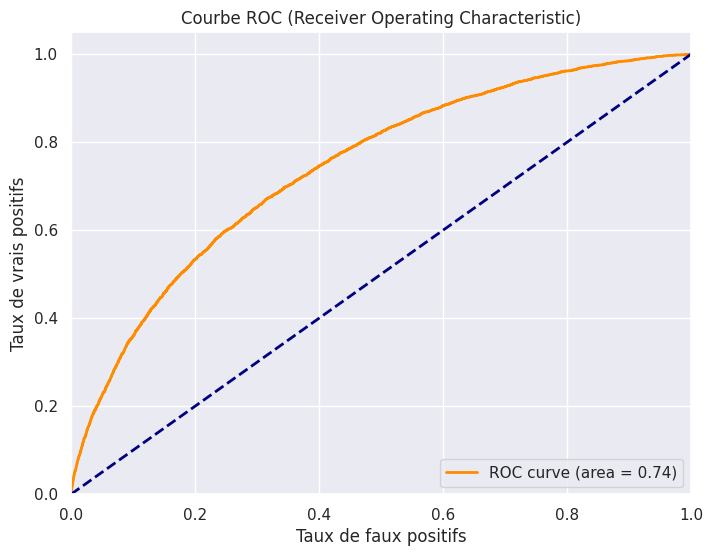

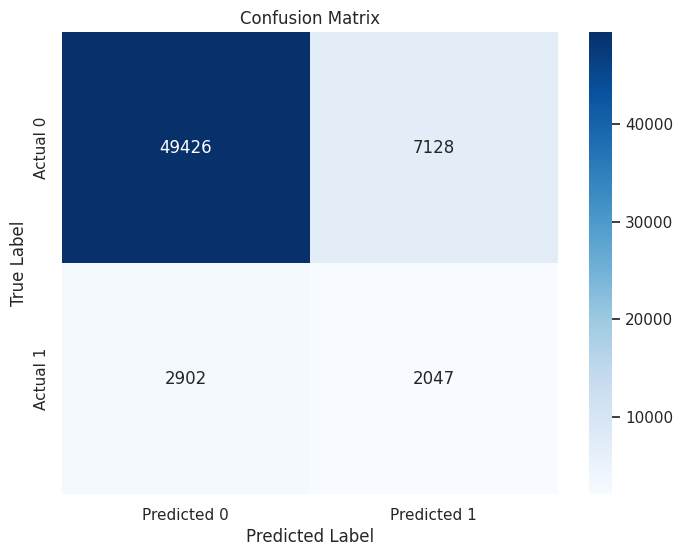

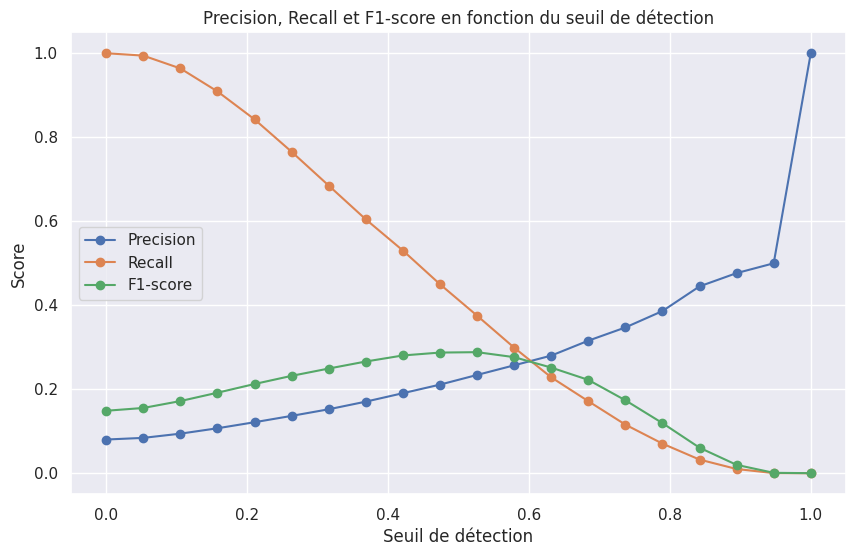

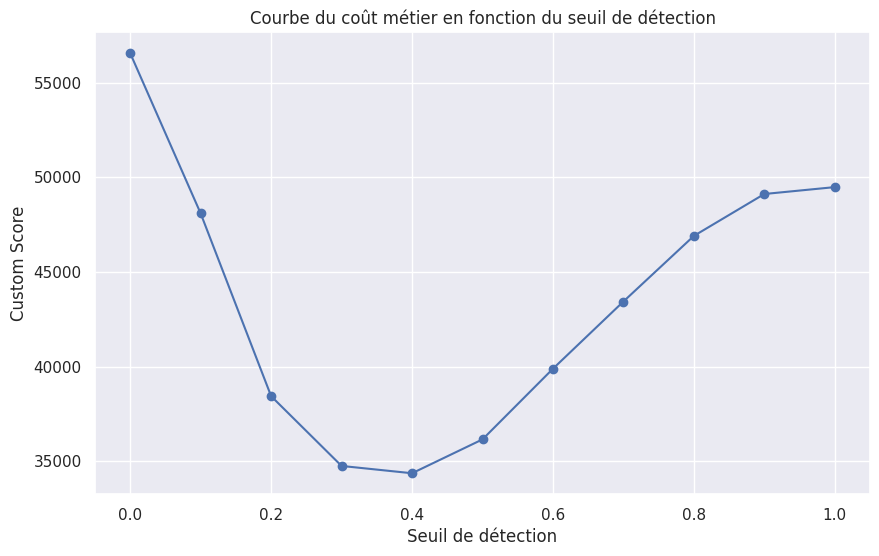

In [40]:
loaded_model_lr_best = load_model(lr_best_filepath)
evaluate_model(loaded_model_lr_best)

### Random Forest

In [41]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_base_filepath = './content/artefacts/model-rf-base.pkl'
is_training = False

if is_training:

    # Initialisation du modèle
    rf_base = RandomForestClassifier(
        n_estimators=500,
        min_samples_split=15,
        n_jobs=-1,
        random_state=42
    )

    # Entraînement du modèle
    rf_base.fit(X_train_resampled, y_train_resampled)

    # Sauvegarde du modèle
    with open(rf_base_filepath, 'wb') as model_file:
        pickle.dump(rf_base, model_file)

CPU times: user 9 μs, sys: 0 ns, total: 9 μs
Wall time: 11.7 μs


              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56554
           1       0.37      0.04      0.07      4949

    accuracy                           0.92     61503
   macro avg       0.65      0.52      0.51     61503
weighted avg       0.88      0.92      0.89     61503

ROC AUC Score : 0.7320918193526011
Recall Score : 0.036977167104465546
Precision : 0.3719512195121951
F1 Score : 0.06726704649880537
F2 Score : 0.04510055205047318


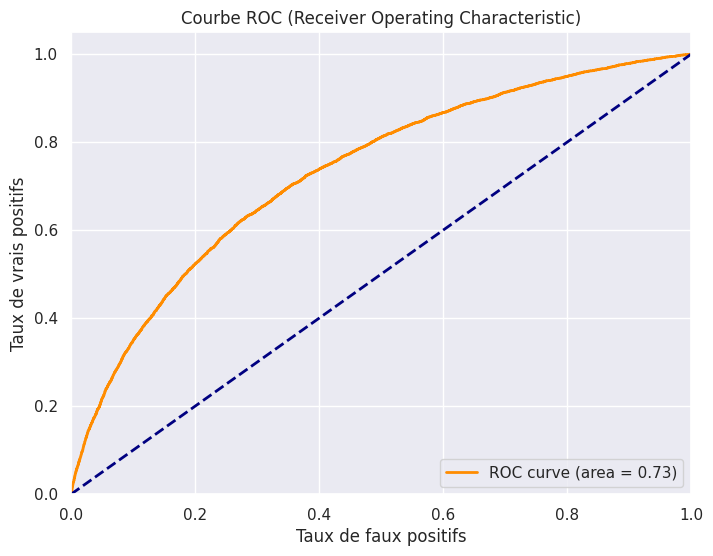

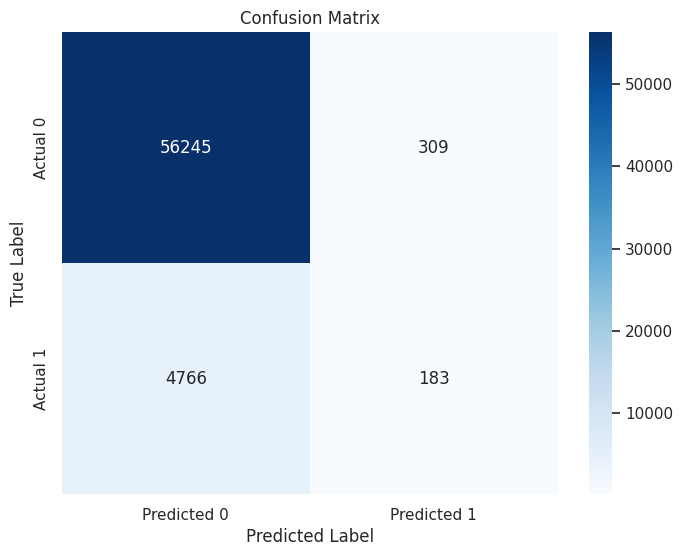

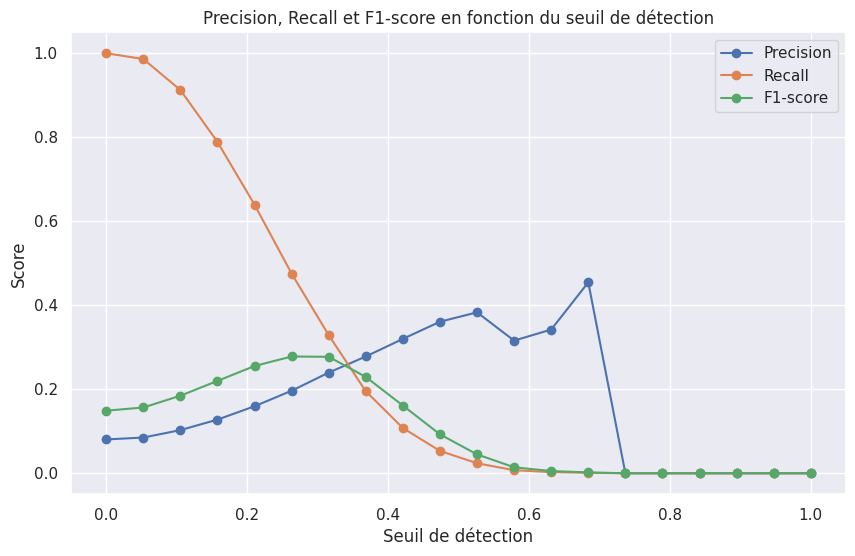

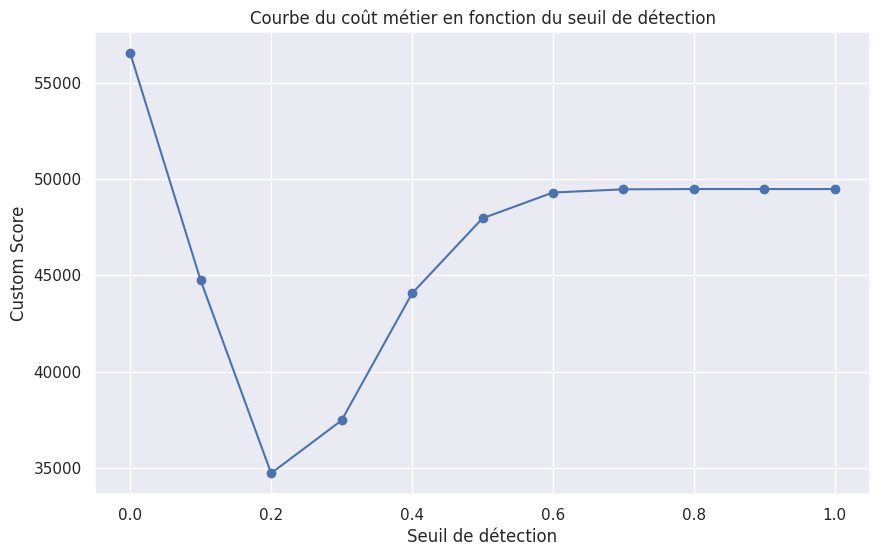

In [42]:
loaded_rf_base = load_model(rf_base_filepath)
evaluate_model(loaded_rf_base)

#### GridSearchCV

In [43]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_best_filepath = './content/artefacts/model-rf-best.pkl'
is_training = False

if is_training:

    rf_best = RandomForestClassifier(
        n_estimators=100, # Default
        n_jobs=-1,
        random_state=42
    )

    param_grid = {
        'max_depth': [None, 5, 10, 15],
        'min_samples_split': [2, 5, 10]
    }

    rf_grid_search = GridSearchCV(
        estimator=rf_best,
        param_grid=param_grid, 
        cv=5,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    # Fit GridSearchCV
    rf_grid_search.fit(X_train_resampled, y_train_resampled)

    # Display the best parameters and the best score
    print("Best Parameters:", rf_grid_search.best_params_)
    print("Best Cross-Validation Score:", rf_grid_search.best_score_)

    # Save the best model
    model_rf_best = rf_grid_search.best_estimator_
    with open(rf_best_filepath, 'wb') as model_file:
        pickle.dump(model_rf_best, model_file)

CPU times: user 15 μs, sys: 1 μs, total: 16 μs
Wall time: 20.5 μs


- Best Parameters: {'max_depth': None, 'min_samples_split': 2}
- Best Cross-Validation Score: 0.9480804203631406
- CPU times: user 3min 42s, sys: 3.99 s, total: 3min 46s
- Wall time: 13min 2s

In [44]:
loaded_model_rf_best = load_model(rf_best_filepath)
loaded_model_lr_best.get_params()

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1500,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56554
           1       0.34      0.04      0.07      4949

    accuracy                           0.92     61503
   macro avg       0.63      0.52      0.51     61503
weighted avg       0.87      0.92      0.88     61503

ROC AUC Score : 0.7242602844090531
Recall Score : 0.036775106082036775
Precision : 0.3382899628252788
F1 Score : 0.06633861855294332
F2 Score : 0.04475263106127668


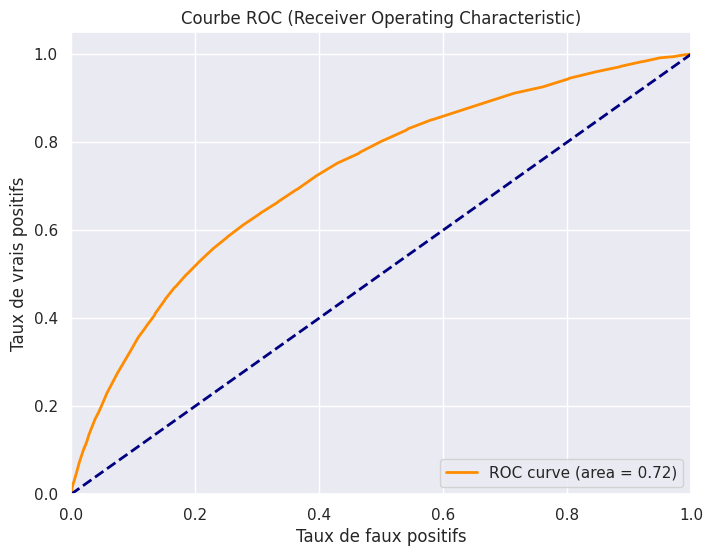

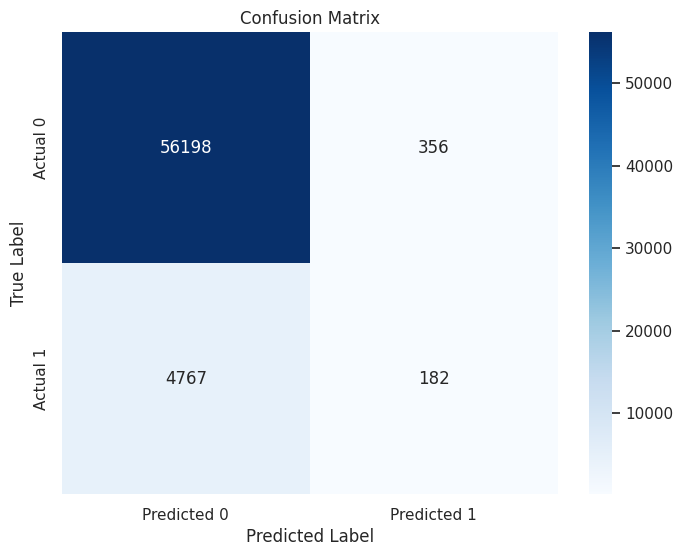

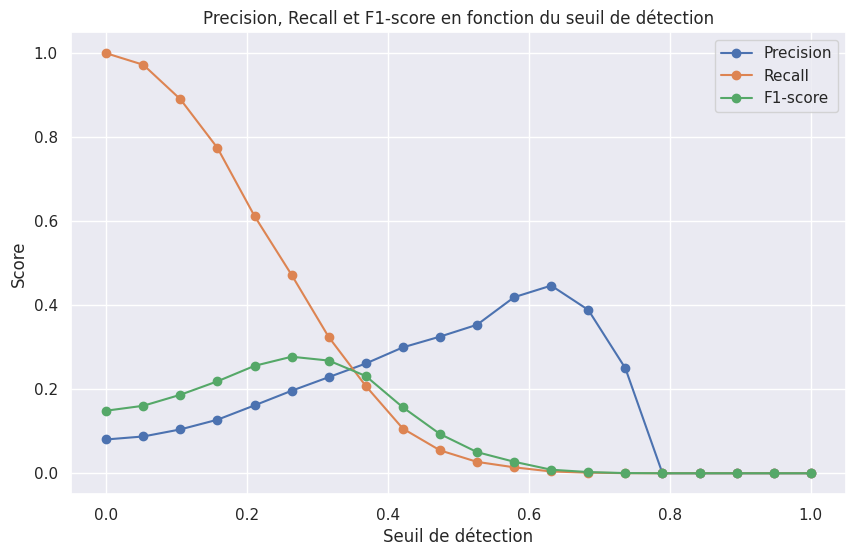

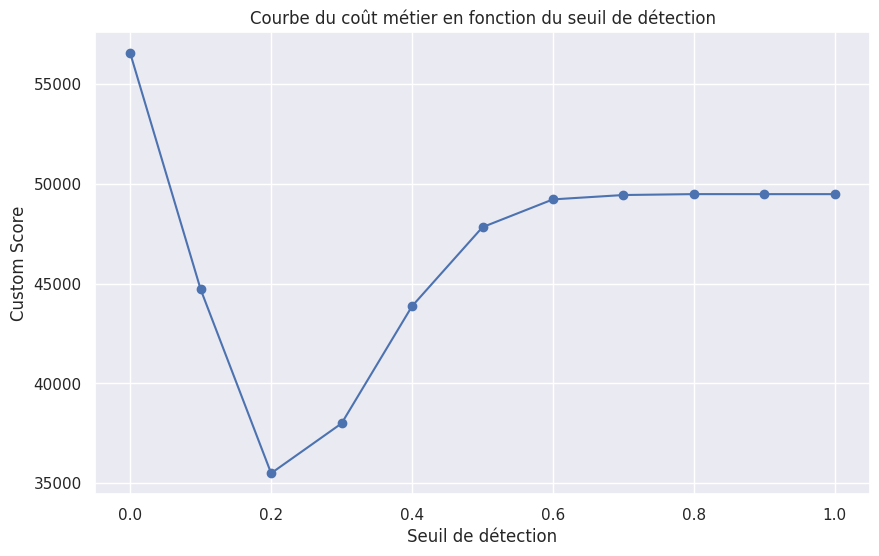

In [45]:
evaluate_model(loaded_model_rf_best)

### Gradient Boosting

#### Base

In [46]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gbc_base_filepath = './content/artefacts/model-gbc-base.pkl'
is_training = False

if is_training:

    gbc_base = GradientBoostingClassifier(random_state=42)

    gbc_base.fit(X_train_resampled, y_train_resampled)

    with open(gbc_base_filepath, 'wb') as model_file:
        pickle.dump(gbc_base, model_file)

CPU times: user 16 μs, sys: 2 μs, total: 18 μs
Wall time: 21 μs


In [47]:
loaded_model_gbc_base = load_model(gbc_base_filepath)
loaded_model_gbc_base.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56554
           1       0.34      0.07      0.11      4949

    accuracy                           0.91     61503
   macro avg       0.63      0.53      0.53     61503
weighted avg       0.88      0.91      0.89     61503

ROC AUC Score : 0.7366293744733967
Recall Score : 0.06506364922206506
Precision : 0.34328358208955223
F1 Score : 0.10939357907253269
F2 Score : 0.07765023632680622


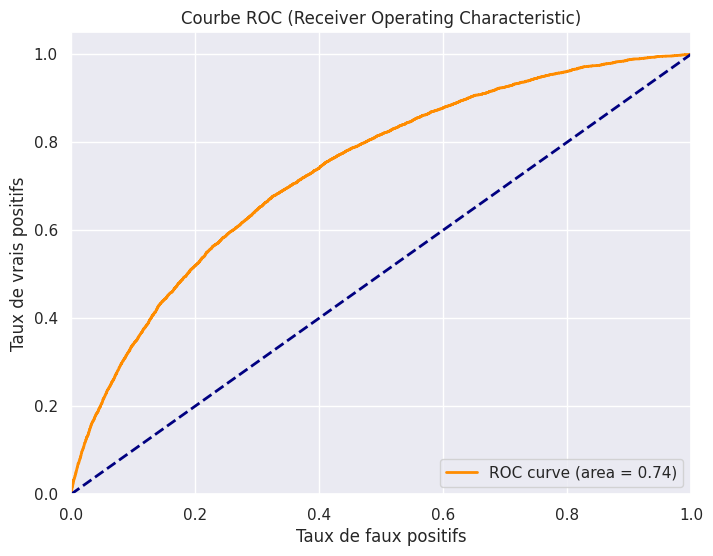

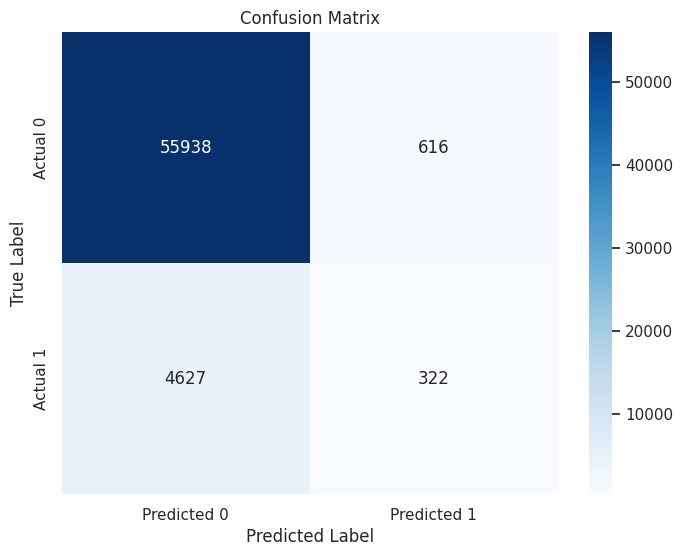

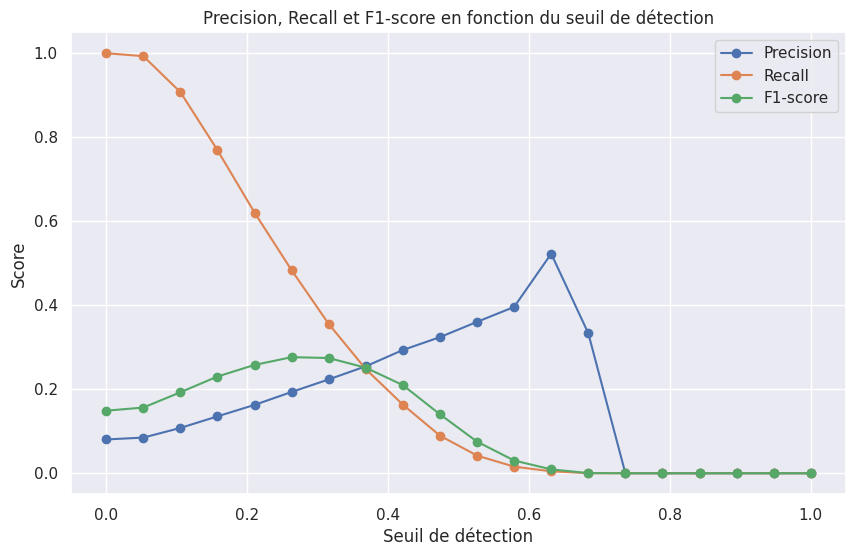

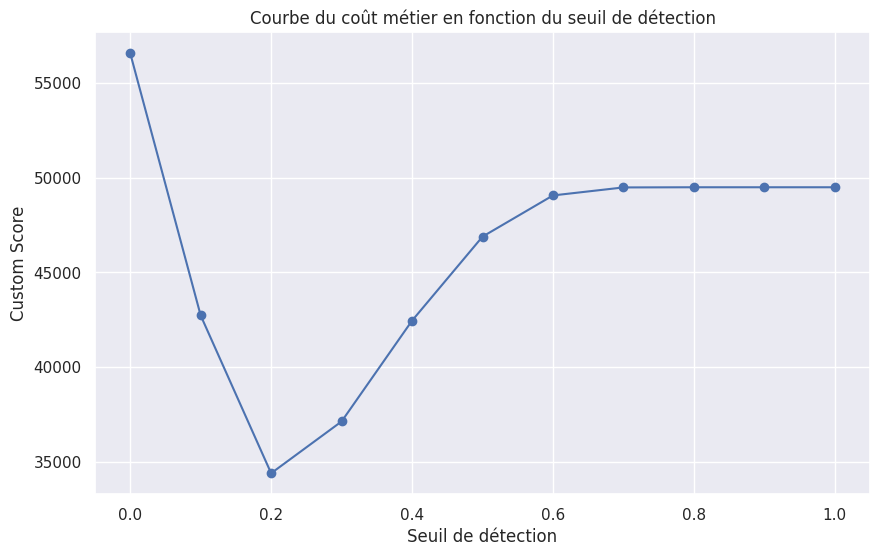

In [48]:
evaluate_model(loaded_model_gbc_base)

#### GridSearchCV

In [49]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

is_training = False
gbc_best_filepath = './content/artefacts/model-gbc-best.pkl'

if is_training:

    # Initialize the Random Forest classifier
    gbc_best = GradientBoostingClassifier(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
        'max_depth': [1, 3, 5],
        'min_samples_split': [2, 5, 10],
        'learning_rate': [0.01, 0.1, 1]
    }

    # Initialize GridSearchCV
    gbc_grid_search = GridSearchCV(
        estimator=gbc_best,
        param_grid=param_grid, 
        cv=5,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    # Fit GridSearchCV
    gbc_grid_search.fit(X_train_resampled, y_train_resampled)

    # Display the best parameters and the best score
    print("Best Parameters:", gbc_grid_search.best_params_)
    print("Best Cross-Validation Score:", gbc_grid_search.best_score_)

    # Save the best model
    model_gbc_best = gbc_grid_search.best_estimator_
    with open(gbc_best_filepath, 'wb') as model_file:
        pickle.dump(model_gbc_best, model_file)

# 566 mins

CPU times: user 17 μs, sys: 2 μs, total: 19 μs
Wall time: 22.9 μs


In [50]:
loaded_model_gbc_best = load_model(gbc_best_filepath)
loaded_model_gbc_best.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     56554
           1       0.40      0.09      0.15      4949

    accuracy                           0.92     61503
   macro avg       0.66      0.54      0.55     61503
weighted avg       0.88      0.92      0.89     61503

ROC AUC Score : 0.7619715260526343
Recall Score : 0.09355425338452213
Precision : 0.4005190311418685
F1 Score : 0.15167895167895168
F2 Score : 0.11049064528445972


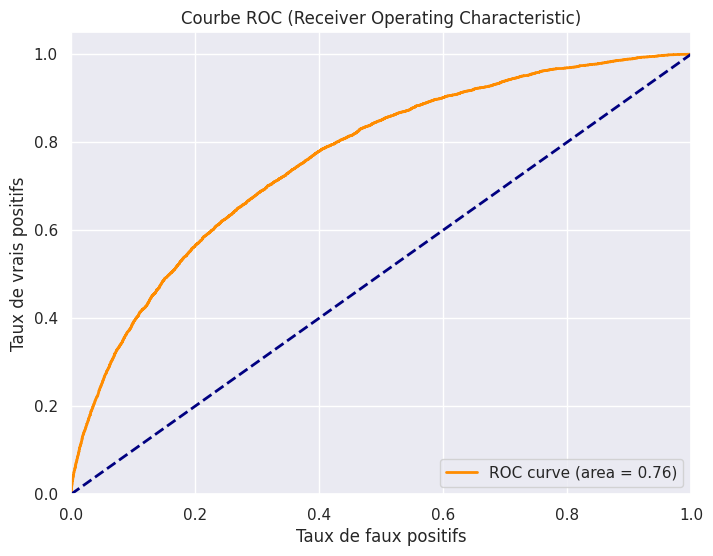

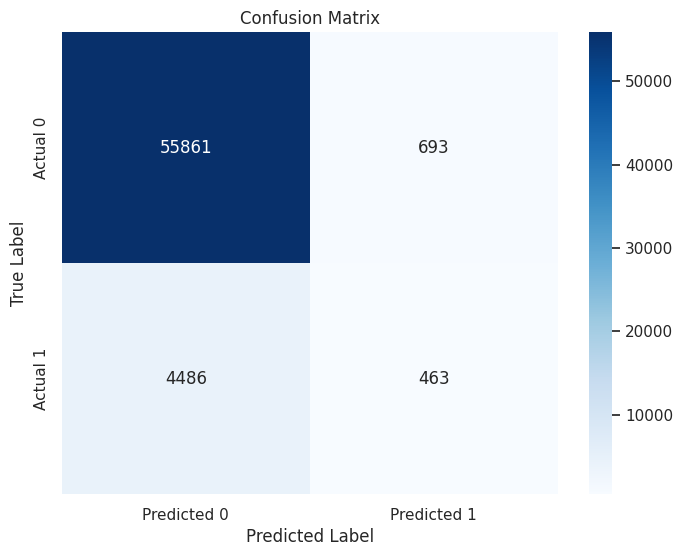

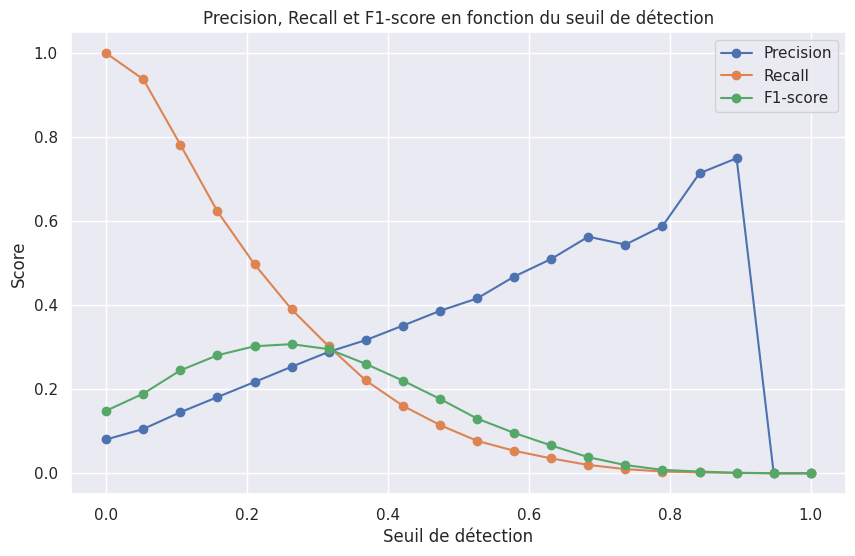

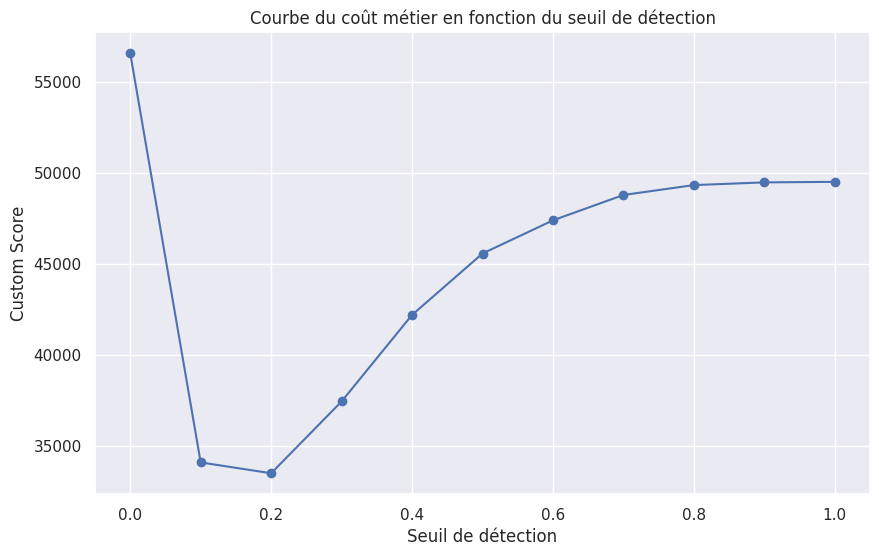

In [51]:
evaluate_model(loaded_model_gbc_best)

## Explicabilité du modèle

>  Analyse de l’importance des variables globale au modèle, mais également locale pour un client donné.

- Utilisation des librairies spécialisées pour calculer la **feature importance** globale et locale.
- Informations fournies pour expliquer les prédictions du modèle aux chargés d'étude.

Comprendre l'importance des variables dans un modèle de machine learning est crucial pour plusieurs raisons :

1. **Comprendre l'importance des caractéristiques :** Identifier les variables qui influencent le plus les prédictions.  
2. **Sélection de variables pertinentes :** Réduire la complexité du modèle en choisissant les variables les plus importantes.  
3. **Améliorer les performances :** Optimiser les algorithmes et ajuster les hyperparamètres en se concentrant sur les variables clés.  
4. **Réduction des biais :** Identifier et atténuer les biais potentiels dans les données ou le modèle.  
5. **Améliorer la généralisation :** Renforcer la capacité du modèle à s'adapter à de nouvelles données grâce à une sélection efficace des variables.  
6. **Prise en compte du contexte :** Intégrer les spécificités du problème pour une meilleure interprétation et adaptation.  
7. **Respect des considérations éthiques et juridiques :** Assurer la non-discrimination et la conformité avec les lois en vigueur.  

**Documentation** :
- https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f
- https://christophm.github.io/interpretable-ml-book/
- https://www.aquiladata.fr/insights/interpretabilite-des-modeles-de-machine-learning/
- https://datacorner.fr/feature-importance/

In [52]:
# loaded_model_lr_best
# loaded_model_rf_best
# loaded_model_gbc_best

### Interprétabilité du modèle de régression logistique `loaded_model_lr_best`

> Dans les processus d'approbation de prêts, notamment en cas de rejet, les banques doivent expliquer au client les raisons qui ont motivé la décision.

Bien que la régression logistique soit souvent considérée comme interprétable en raison de sa nature linéaire, elle présente certaines limites. Les coefficients bruts indiquent la direction (impact positif ou négatif) mais **ne capturent pas toute la complexité**, notamment les interactions entre variables ou les effets non linéaires.

C’est là que SHAP intervient, offrant une quantification et une visualisation précises de la contribution de chaque caractéristique, même lorsque les relations ne sont pas simples. En combinant les valeurs SHAP avec la régression logistique, on bénéficie à la fois de la **simplicité d’un modèle linéaire** et de la **profondeur d’un outil d’interprétabilité avancé**.

Pour obtenir une interprétabilité globale et locale de notre modèle `loaded_model_lr_best`, nous pouvons utiliser des bibliothèques comme **SHAP** (SHapley Additive exPlanations).

#### Différence entre Interprétabilité Globale et Locale :  

1. **Interprétabilité Globale :**  
   - Permet d’identifier les caractéristiques les plus importantes sur l’ensemble du jeu de données.  
   - Offre une vue d’ensemble du comportement du modèle, en montrant les variables qui influencent le plus ses décisions globales.  
   - Crucial pour comprendre le fonctionnement du modèle à grande échelle.  

2. **Interprétabilité Locale :**  
   - Se concentre sur les prédictions individuelles.  
   - Répond à la question : *"Pourquoi le modèle a-t-il fait cette prédiction spécifique pour cet échantillon précis ?"*.  
   - Très utile pour justifier ou expliquer une décision particulière, comme dans le cas  d’une demande de prêt en finance.  


**Documentation**

- https://shap.readthedocs.io/en/latest/index.html
- https://github.com/shap/shap
- https://medium.com/biased-algorithms/shap-values-for-logistic-regression-51ffa5bdcedc



In [53]:
# Retrouver le noms des colonnes One-Hot Encodées 
ohe_feature_names = preprocessor.named_transformers_['pp_cat']['cat_ohe'].get_feature_names_out(cat_cols)

# Combiner les colonnes transformées
all_feature_names = np.concatenate([
    ohe_feature_names,                # Colonnes catégoriques encodées
    binary_cols,                      # Colonnes binaires (inchangées)
    quantity_cols,                    # Colonnes quantitatives
    normalized_cols,                  # Colonnes normalisées
    rating_cols                       # Colonnes notation
])


In [54]:
# Afficher les noms des colonnes catégorielles encodées
print("Nombres de colonnes catégorielles One-Hot encodées : ", len(ohe_feature_names), "\n")
for name in ohe_feature_names:
    print(name)

Nombres de colonnes catégorielles One-Hot encodées :  118 

CODE_GENDER_M
CODE_GENDER_XNA
NAME_CONTRACT_TYPE_Revolving loans
NAME_TYPE_SUITE_Family
NAME_TYPE_SUITE_Group of people
NAME_TYPE_SUITE_Other_A
NAME_TYPE_SUITE_Other_B
NAME_TYPE_SUITE_Spouse, partner
NAME_TYPE_SUITE_Unaccompanied
NAME_INCOME_TYPE_Other
NAME_INCOME_TYPE_Pensioner
NAME_INCOME_TYPE_State servant
NAME_INCOME_TYPE_Working
NAME_EDUCATION_TYPE_Higher education
NAME_EDUCATION_TYPE_Incomplete higher
NAME_EDUCATION_TYPE_Lower secondary
NAME_EDUCATION_TYPE_Secondary / secondary special
NAME_FAMILY_STATUS_Married
NAME_FAMILY_STATUS_Separated
NAME_FAMILY_STATUS_Single / not married
NAME_FAMILY_STATUS_Unknown
NAME_FAMILY_STATUS_Widow
NAME_HOUSING_TYPE_House / apartment
NAME_HOUSING_TYPE_Municipal apartment
NAME_HOUSING_TYPE_Office apartment
NAME_HOUSING_TYPE_Rented apartment
NAME_HOUSING_TYPE_With parents
OCCUPATION_TYPE_Cleaning staff
OCCUPATION_TYPE_Cooking staff
OCCUPATION_TYPE_Core staff
OCCUPATION_TYPE_Drivers
OCCUPATI

In [55]:
# Réassigner les noms des colonnes catégorielles encodées
X_train_resampled_w_col_names = X_train_resampled.copy()
X_train_resampled_w_col_names.columns = all_feature_names

X_test_preprocessed_w_col_names = X_test_preprocessed.copy()
X_test_preprocessed_w_col_names.columns = all_feature_names

In [56]:
import shap

# Initialize the SHAP explainer
shap_explainer = shap.Explainer(loaded_model_lr_best, X_train_resampled_w_col_names)

# Calculate SHAP values on test data
shap_values = shap_explainer(X_test_preprocessed_w_col_names)

#### Interprétabilité Globale

Visualisation montrant l'importance relative des caractéristiques sur l’ensemble des données. Cela inclut :
- **L'importance des caractéristiques :** Quelles sont les caractéristiques les plus influentes ?
- **La direction de l’impact :** Les valeurs des caractéristiques augmentent-elles ou diminuent-elles les prédictions ?

Le **graphique en violon** est conçu pour afficher un résumé riche en informations sur la manière dont les principales fonctionnalités d’un ensemble de données impactent la sortie du modèle.

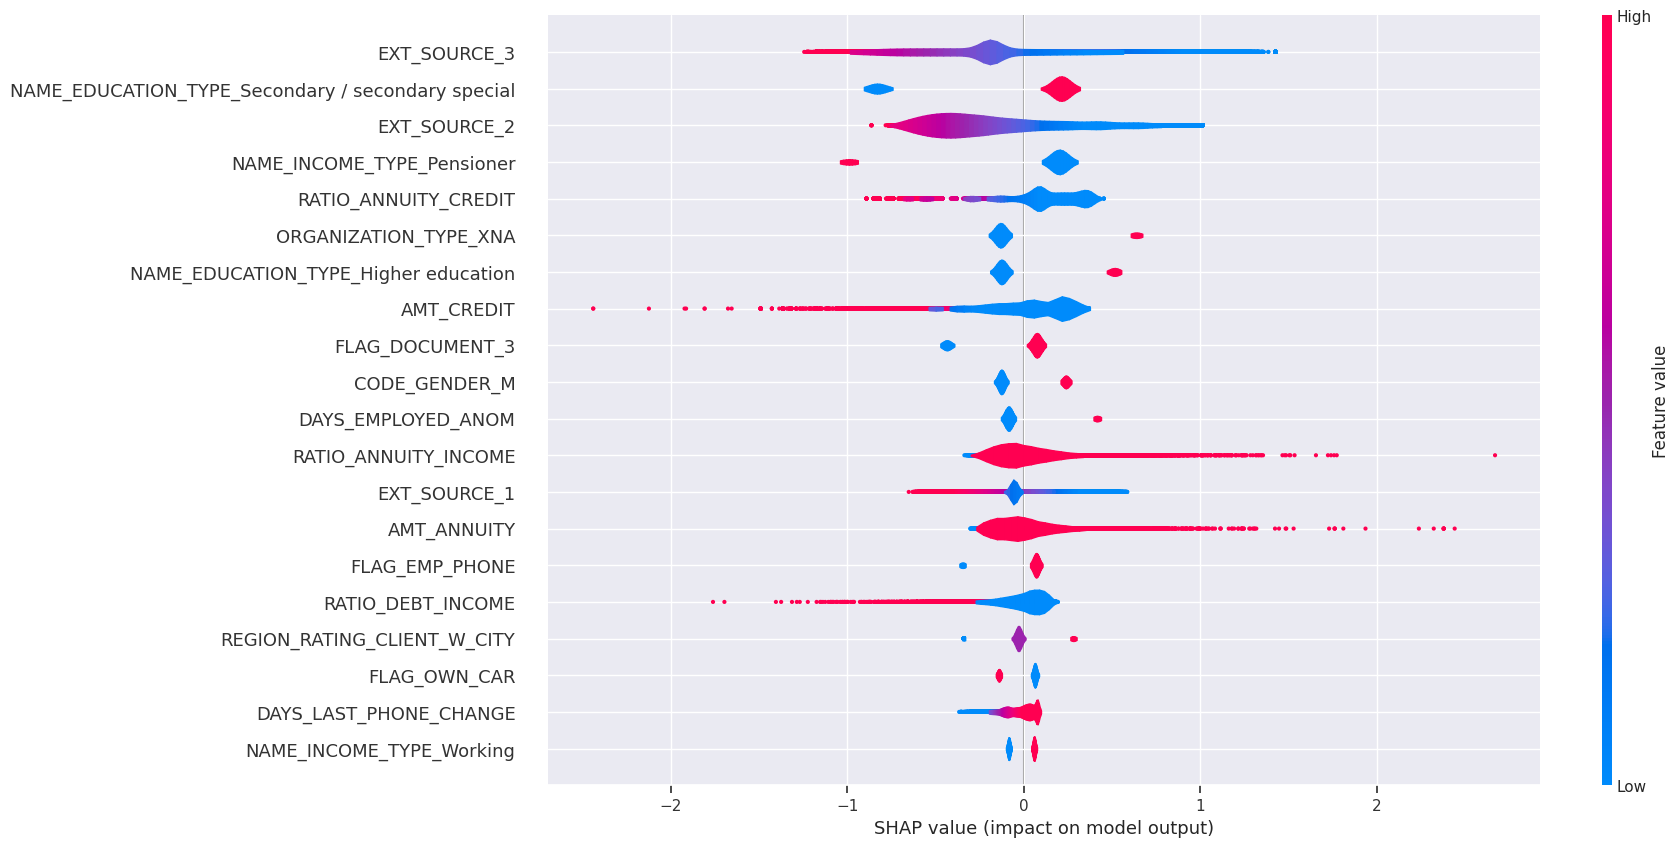

In [57]:
shap.plots.violin(shap_values, plot_size=(16, 10))

Le passage d'une matrice de valeurs SHAP dans la fonction `plots.bar` crée un **graphique d'importance des fonctionnalités globales**, où l'importance globale de chaque fonctionnalité est considérée comme la valeur absolue moyenne de cette fonctionnalité sur tous les échantillons donnés.

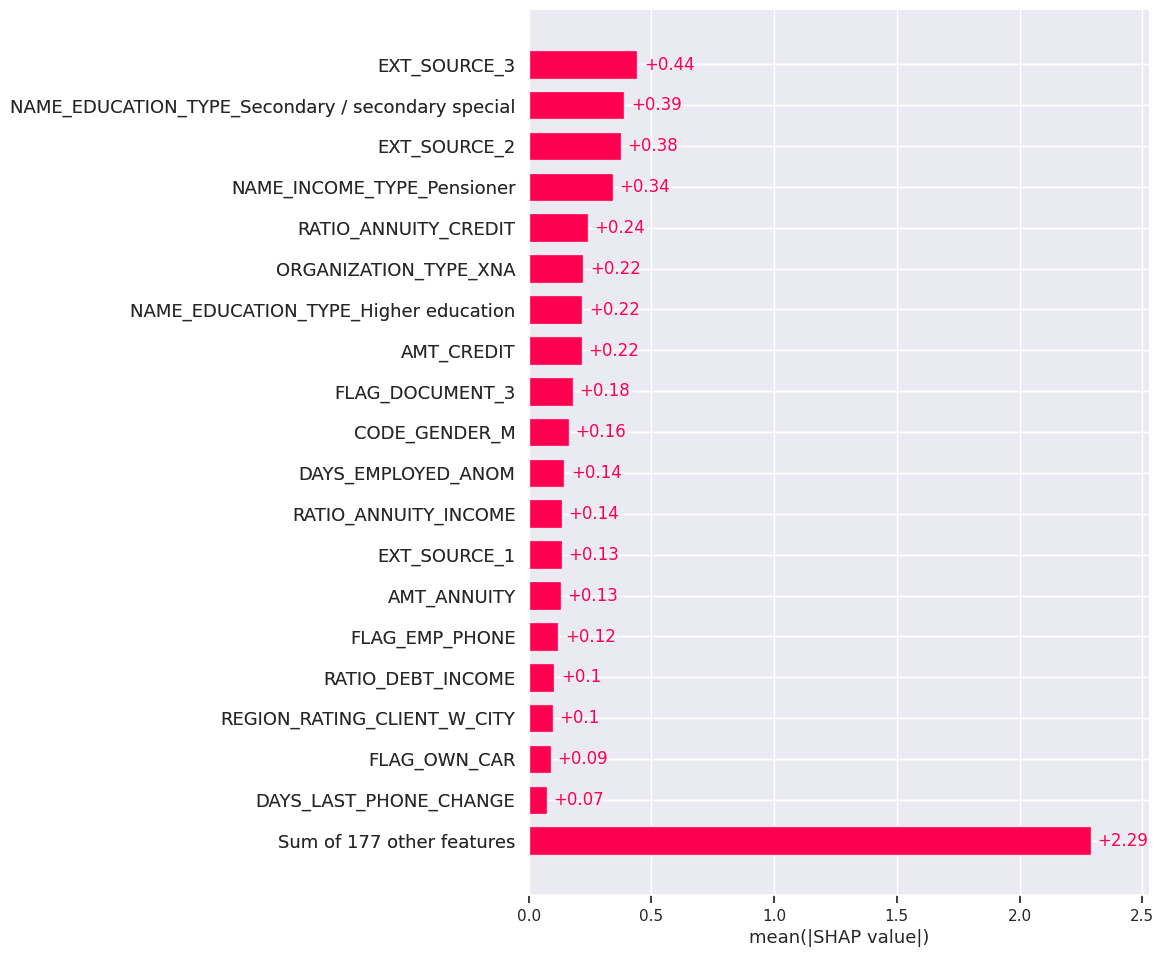

In [58]:
shap.plots.bar(shap_values, max_display=20)

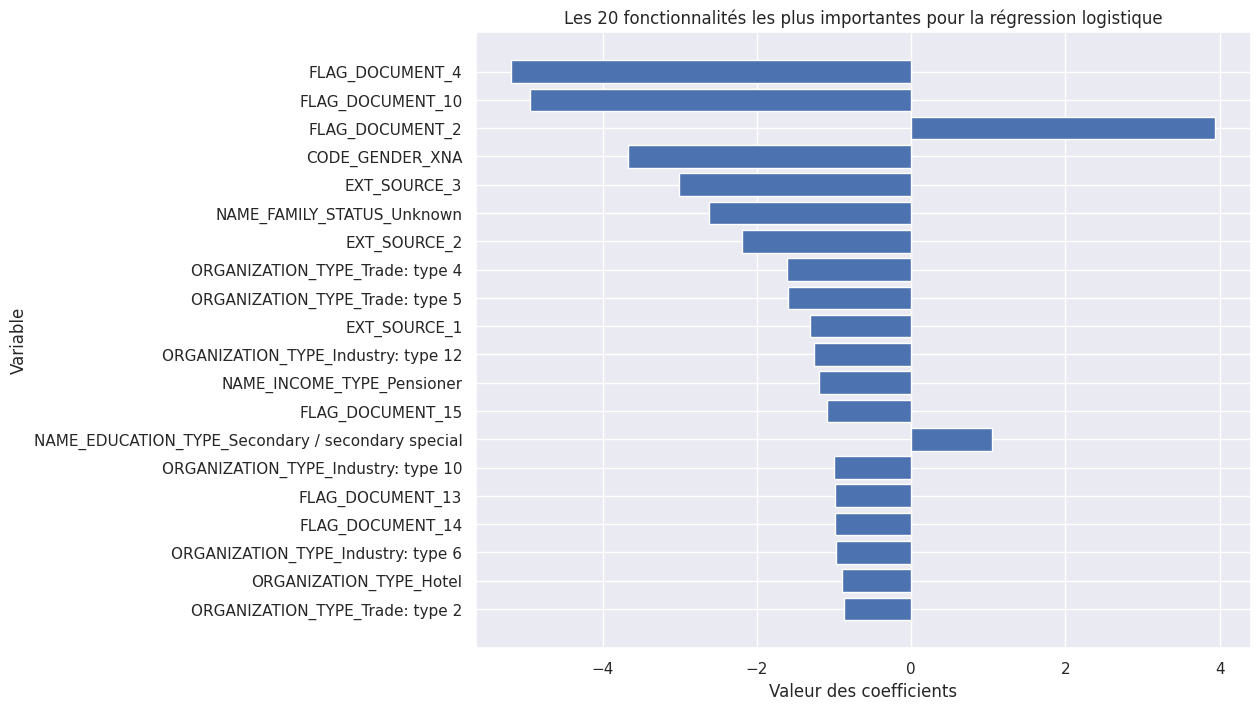

In [62]:
# Get the feature names
feature_names = X_train_resampled_w_col_names.columns

# Get the coefficients from the logistic regression model
coefficients = loaded_model_lr_best.coef_[0]

# Create a DataFrame to hold feature names and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the DataFrame by the absolute value of the coefficients
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

# Select the top 20 most important features
top_20_features = feature_importance.head(20)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Coefficient'])
plt.xlabel('Valeur des coefficients')
plt.ylabel('Variable')
plt.title('Les 20 fonctionnalités les plus importantes pour la régression logistique')
plt.gca().invert_yaxis()
plt.show()

#### Interprétabilité Locale

- **Impact des caractéristiques :** Montre comment chaque caractéristique contribue à une prédiction spécifique.
- **Valeur attendue :** Comparaison de la prédiction avec la valeur moyenne.

##### Test sur un client prédit "défaut de paiement"

In [59]:
print(f"Client (index: 0) - Statut de défaut de paiement : {y_test.iloc[0]}")

Client (index: 0) - Prediction de défaut de paiement : 0


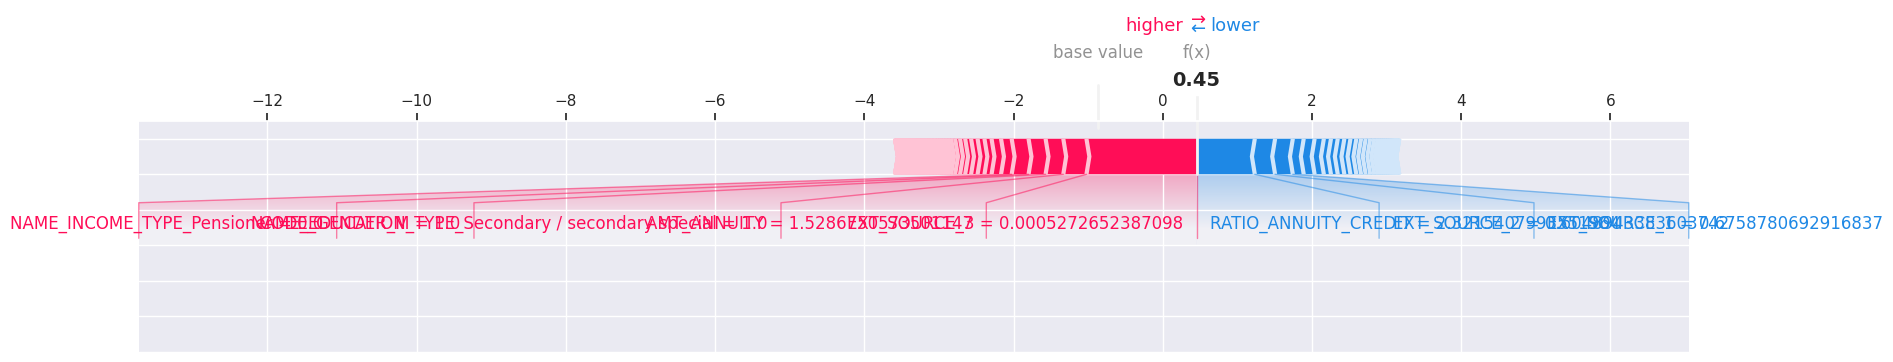

In [60]:
# Interprétabilité locale :
# Expliquer la première instance dans l'ensemble de données de test
shap.plots.force(shap_values[0], matplotlib=True)

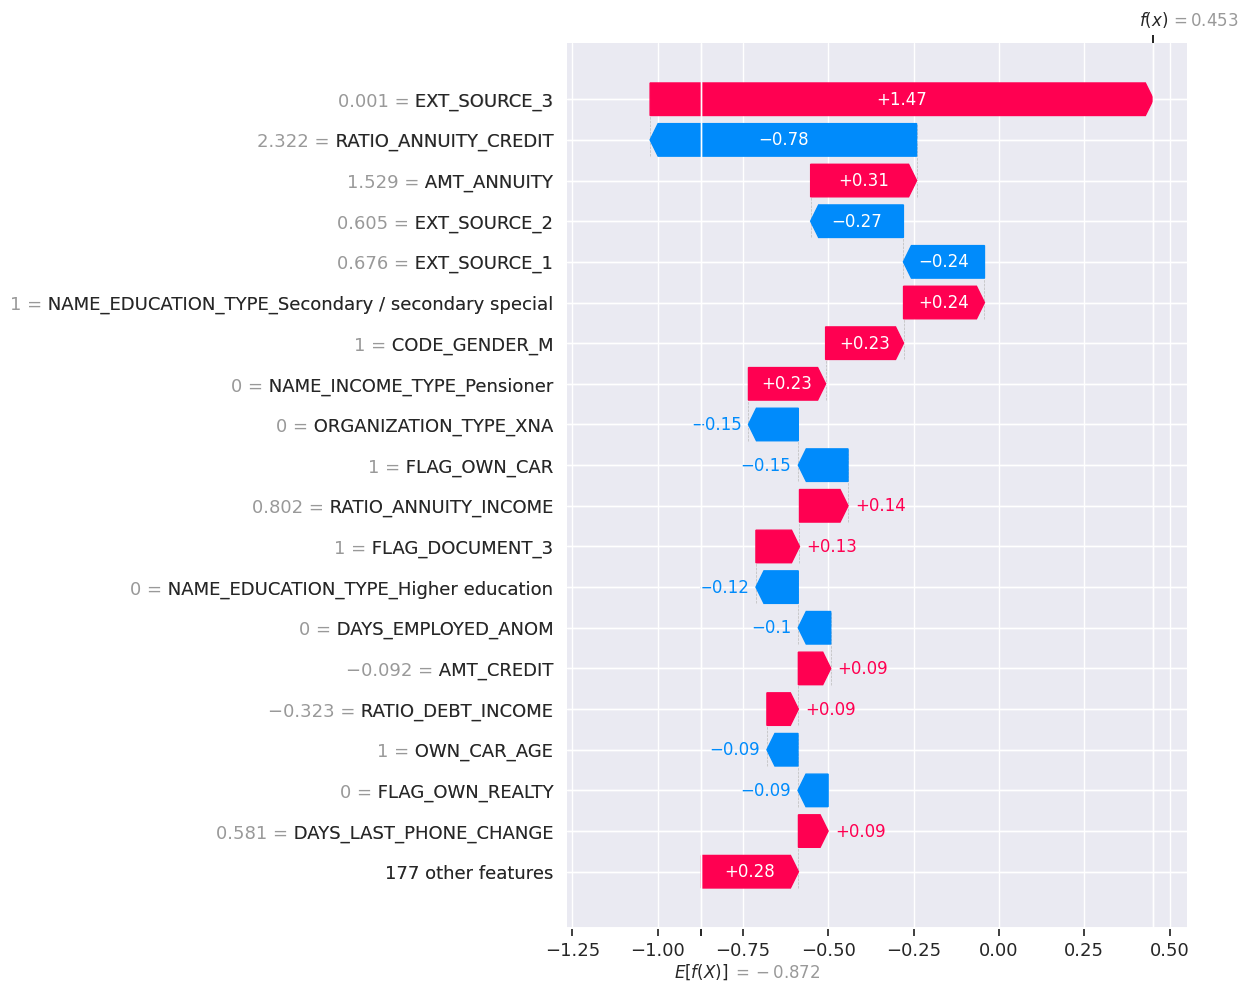

In [61]:
shap.plots.waterfall(shap_values[0], max_display=20)

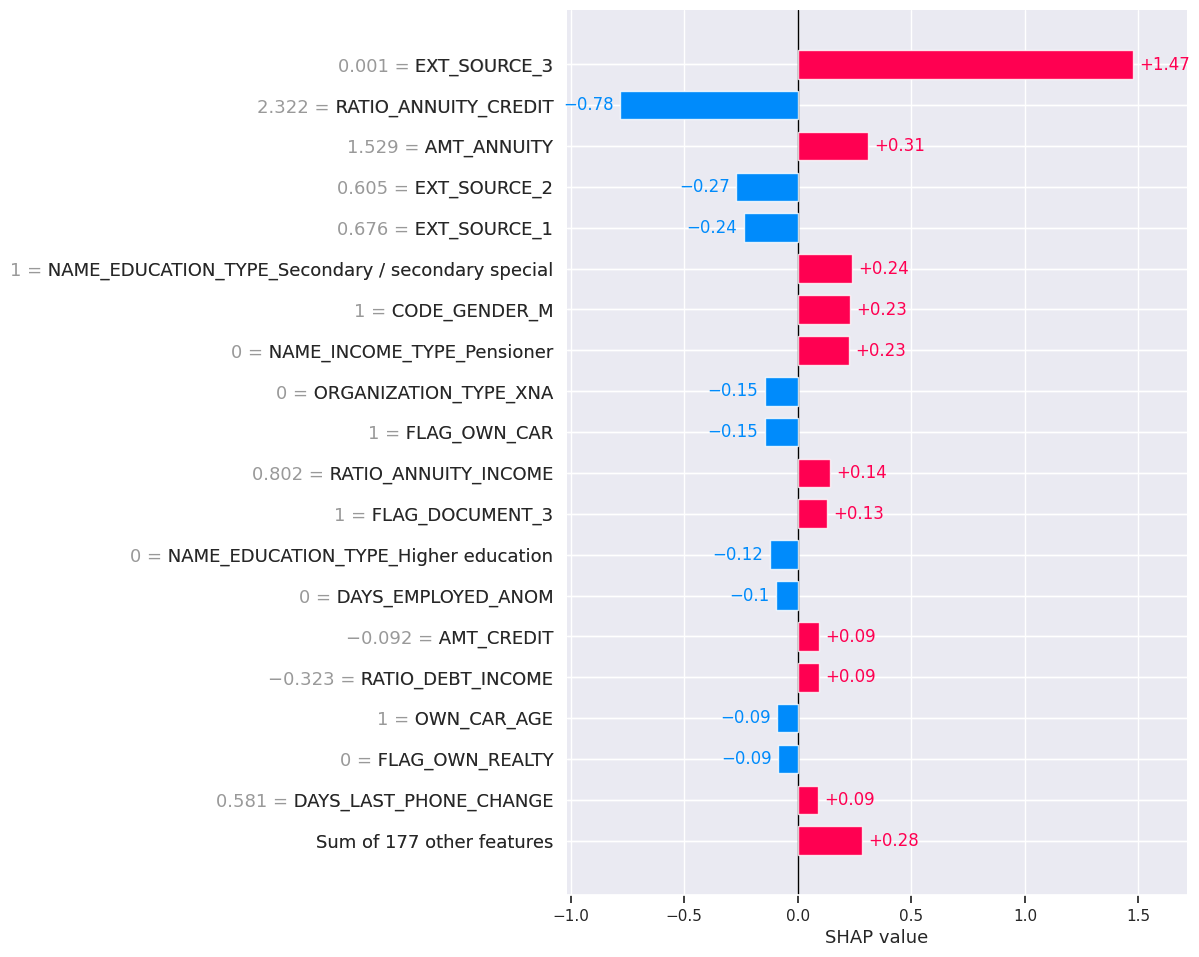

In [62]:
shap.plots.bar(shap_values[0], max_display=20)

##### Test sur un client prédit "non défaut de paiement"

In [63]:
print(f"Client (index: 1) - Statut de défaut de paiement : {y_test.iloc[1]}")

Client (index: 1) - Statut de défaut de paiement : 0


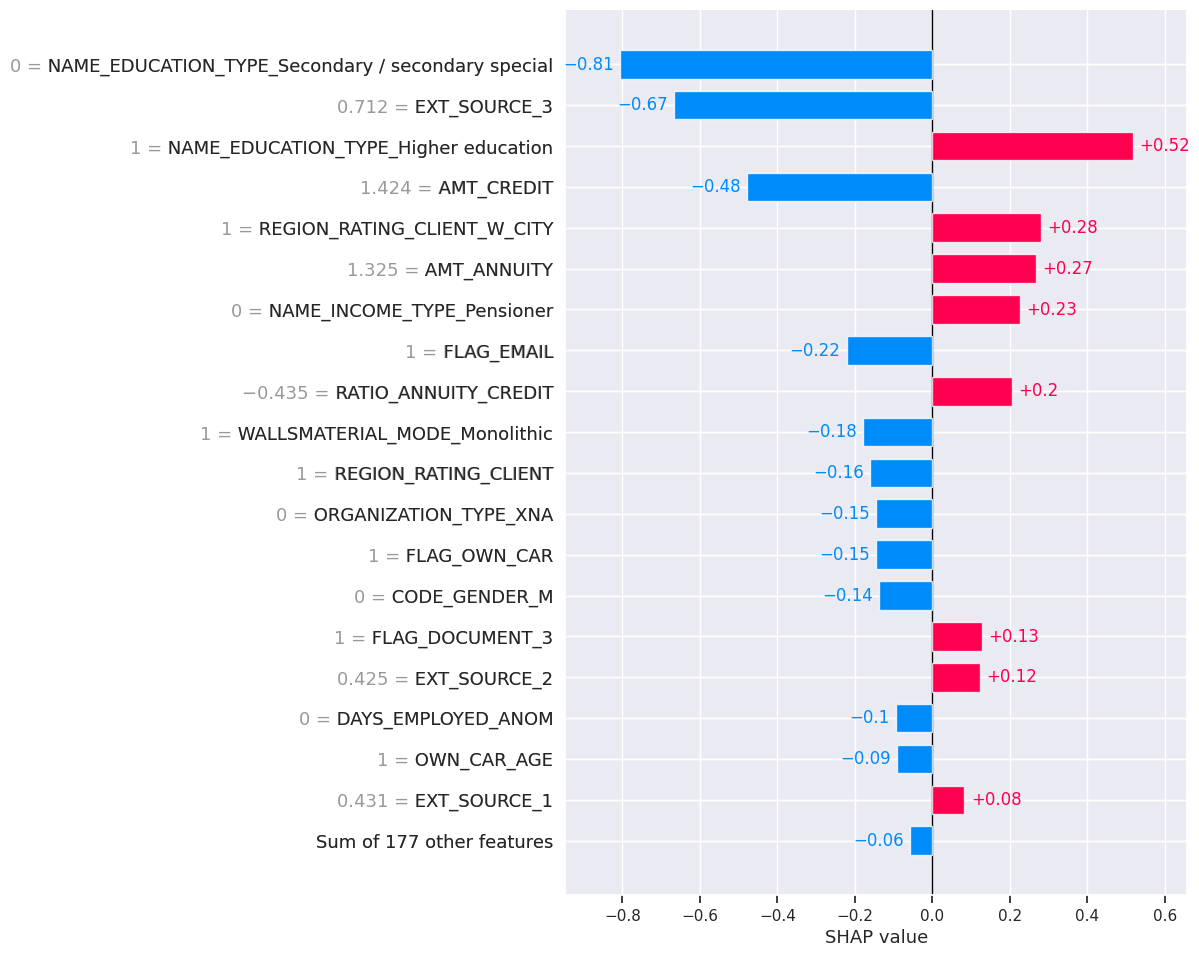

In [64]:
shap.plots.bar(shap_values[1], max_display=20)

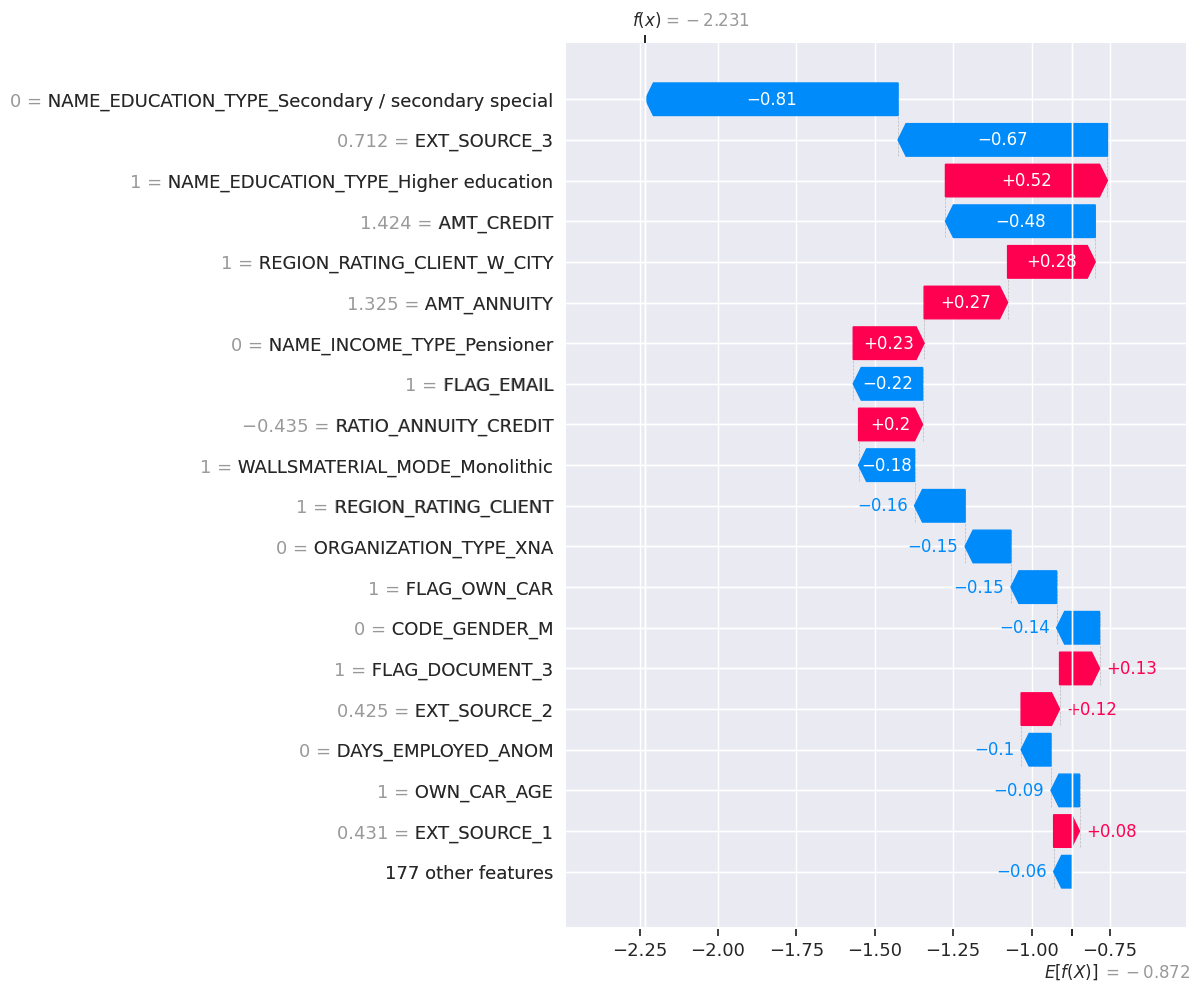

In [65]:
shap.plots.waterfall(shap_values[1], max_display=20)